In [1]:
#%%
from array import array
from cmath import nan
from pyexpat import model
import statistics
from tkinter.ttk import Separator
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchviz import make_dot
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
from torch.autograd import variable
from itertools import chain
from sklearn import metrics as met
import pickle
from icecream import ic

import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from importlib import reload
# import util
# import model_torch_simple
# from torchmetrics import Accuracy
from tqdm import tqdm
import argparse
from icecream import ic
import numpy as np
from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [2]:
seed = 42
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

In [3]:
def value_counts_list(lst):
    """
    Computes the frequency count of unique elements in a list and returns a dictionary, sorted by frequency count in
    descending order.

    Args:
    - lst (list): List of elements

    Returns:
    - dict: Dictionary with unique elements as keys and their frequency count as values, sorted by frequency count
    in descending order
    """
    value_counts = {}
    for item in lst:
        if item in value_counts:
            value_counts[item] += 1
        else:
            value_counts[item] = 1
    sorted_value_counts = dict(sorted(value_counts.items(), key=lambda x: x[1], reverse=True))
    return sorted_value_counts

def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

### Loading data

In [47]:
train_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_rif/aa_data_train.csv', delimiter = ',')
train_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_rif/mic_aa_train_hml3.csv')
train_target = train_target[['RIF_MIC']]
# don't touch test data, split out validation data from training data during training
# test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_rif/aa_data_test_pca4k.csv', delimiter = ',')
test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_rif/aa_data_test.csv', delimiter = ',')
test_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_rif/mic_aa_test_hml3.csv')
test_target = test_target[['RIF_MIC']]

In [54]:
all_data = np.concatenate((train_data, test_data), axis=0)
all_target = pd.concat((train_target, test_target), axis=0)

In [55]:
train_data, test_data, train_target, test_target = train_test_split(all_data, all_target, test_size=0.2, random_state=42, stratify=all_target)


In [5]:
# valid_indices = train_target.dropna().index
# train_target = train_target.loc[valid_indices]
# train_data = train_data[valid_indices]

# valid_indices = test_target.dropna().index
# test_target = test_target.loc[valid_indices]
# test_data = test_data[valid_indices] 

In [64]:
N_samples = train_data.shape[0]
DRUGS = train_target.columns
# LOCI = train_data.columns
assert set(DRUGS) == set(train_target.columns)
N_drugs = len(DRUGS)

# Feature engineering

In [65]:
# def one_hot_torch(seq: str, dtype=torch.int8):
#     seq_bytes = torch.ByteTensor(list(bytes(seq, "utf-8")))
#     acgt_bytes = torch.ByteTensor(list(bytes("ACGT", "utf-8")))
#     arr = torch.zeros(6, (len(seq_bytes)), dtype=dtype)
#     arr[0, seq_bytes == acgt_bytes[0]] = 1
#     arr[1, seq_bytes == acgt_bytes[1]] = 1
#     arr[2, seq_bytes == acgt_bytes[2]] = 1
#     arr[3, seq_bytes == acgt_bytes[3]] = 1
#     arr[4, seq_bytes == acgt_bytes[3]] = 1
#     arr[5, seq_bytes == acgt_bytes[3]] = 1
#     return arr



# def one_hot_torch(category: int, num_categories: int = 6, dtype=torch.int8):
#     # Ensure the category is valid
#     category -= 1
#     if not (0 <= category < num_categories):
#         raise ValueError("Category out of range")

#     # Create a tensor of zeros with shape (num_categories,)
#     arr = torch.zeros(num_categories, dtype=dtype)
    
#     # Set the corresponding category index to 1
#     arr[category] = 1
#     return arr

# def one_hot_torch(seq):
#     oh = []
#     for sample in seq:
#         sample = torch.ByteTensor(list(bytes(sample, "utf-8")))
#         acgt_bytes = torch.ByteTensor(list(bytes("ACGT", "utf-8")))
#         arr = torch.zeros((len(sample), 4), dtype=torch.int8)
#         arr[sample == acgt_bytes[0], 0] = 1
#         arr[sample == acgt_bytes[1], 1] = 1
#         arr[sample == acgt_bytes[2], 2] = 1
#         arr[sample == acgt_bytes[3], 3] = 1
#         oh.append(arr)
#     return torch.stack(oh)

def my_padding(seq_tuple):
    list_x_ = list(seq_tuple)
    max_len = len(max(list_x_, key=len))
    for i, x in enumerate(list_x_):
        list_x_[i] = x + "N"*(max_len-len(x))
    return list_x_

#! faster than my_padding try to incorporate
def collate_padded_batch(batch):
    # get max length of seqs in batch
    max_len = max([x[0].shape[1] for x in batch])
    return torch.utils.data.default_collate(
        [(F.pad(x[0], (0, max_len - x[0].shape[1])), x[1]) for x in batch] #how does F.pad work
    )



# Dateset

In [66]:
# Julian's code - implement this, might be faster
class Dataset(torch.utils.data.Dataset): #? what's the difference between using inheritance and not?
    def __init__(
        self,
        seq_df,
        res_df,
        # target_loci=LOCI,
        target_drugs=DRUGS,
        one_hot_dtype=torch.int8,
        transform=None,
    ):
        self.transform = transform
        # self.seq_df = seq_df[target_loci]
        self.seq_df = seq_df
        self.res_df = res_df[target_drugs]
        # if not self.seq_df.index.equals(self.res_df.index):
        #     raise ValueError(
        #         "Indices of sequence and resistance dataframes don't match up"
        #     )
        self.one_hot_dtype = one_hot_dtype

    def __getitem__(self, index):
        """
        numerical index --> get `index`-th sample
        string index --> get sample with name `index`
        """
        if isinstance(index, int):
            seqs_comb = self.seq_df[index]
            res = self.res_df.iloc[index]
        elif isinstance(index, str):
            seqs_comb = self.seq_df[int(index)]
            res = self.res_df.loc[index]
        else:
            raise ValueError(
                "Index needs to be an integer or a sample name present in the dataset"
            )

        if self.transform:
            res = np.log(res)
            
            # self.res_mean = self.res_df.mean()
            # self.res_std = self.res_df.std()
            # res = (res - self.res_mean) / self.res_std
            # res = self.transform(res)
        return torch.unsqueeze(torch.tensor(seqs_comb).float(), 0), torch.tensor(res).long().flatten().squeeze()
    def __len__(self):
        return self.res_df.shape[0]

training_dataset = Dataset(train_data, train_target, one_hot_dtype=torch.float, transform=False)
train_dataset, val_dataset = random_split(training_dataset, [int(len(training_dataset)*0.9), len(training_dataset)-int(len(training_dataset)*0.9)])

### Weighted masked loss

In [67]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# # device = 'cpu'

y_true = train_target
# y_true = pd.concat([train_target, test_target])

column_weight_maps = {}

for column in y_true.columns:
    column_values = y_true[column].dropna().values
    values, counts = np.unique(column_values, return_counts=True)
    frequency = counts / len(column_values)
    
    # Calculate weights as the inverse of frequencies
    weights_inverse = 1/frequency
    # weights_inverse = 1 - frequency
    
    # Normalize weights to ensure they sum up to 1
    weights_normalized = weights_inverse / np.sum(weights_inverse)
    
    # Map each MIC value to its corresponding weight
    weight_map = {value: weight for value, weight in zip(values, weights_normalized)}
    
    column_weight_maps[column] = weight_map

def get_weighted_masked_cross_entropy_loss(column_weight_maps):
    """
    Creates a loss function that computes a weighted cross entropy loss, taking into account class imbalances.
    :param column_weight_maps: Dictionary mapping column names to their corresponding class weight maps.
    """
    def weighted_masked_cross_entropy_loss(y_pred, y_true):
        # weighted_losses = torch.Tensor().to(device)
        weighted_losses = []
        col_weight_map = column_weight_maps
        # print(col_weight_map)
        mean_weight = np.mean(list(col_weight_map.values())) # just in case if a number is not recognised and the loss doesn't go crazy

        # print(y_pred.size())
        # Assuming y_true is a tensor of class indices for each column and y_pred are the logits
        weights_col = [col_weight_map.get(y.item(), mean_weight) for y in y_true]
        # print(weights_col)
        # CrossEntropyLoss expects class indices as y_true, and logits as y_pred
        loss_fn = F.cross_entropy
        col_loss = loss_fn(y_pred, y_true, reduction = 'none').to(device)
        
        # loss_fn = nn.CrossEntropyLoss(reduction = 'none')
        # col_loss = loss_fn(y_pred, y_true)
        # print(y_true.dtype)
        # print(col_loss)
        weights_col = torch.Tensor(weights_col).to(device)
        # print(weights_col)
        # print(col_loss)
        weighted_col_loss = weights_col * col_loss
        # print(weighted_col_loss)
        weighted_losses.append(weighted_col_loss.mean())

        total_weighted_loss = torch.stack(weighted_losses).mean()
        
        # for i, column in enumerate(column_weight_maps.keys()):
        #     col_weight_map = column_weight_maps[column]
        #     print(y_pred.size())
        #     # Assuming y_true is a tensor of class indices for each column and y_pred are the logits
        #     weights_col = torch.tensor([col_weight_map[y.item()] for y in y_true[:, i]], dtype=torch.float32, device=y_true.device)
        #     print(weights_col)
        #     # CrossEntropyLoss expects class indices as y_true, and logits as y_pred
        #     loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
        #     col_loss = loss_fn(y_pred[:, i,], y_true[:, i])
            
        #     weighted_col_loss = weights_col * col_loss
        #     weighted_losses.append(weighted_col_loss.mean())
        
        # total_weighted_loss = torch.stack(weighted_losses).mean()
        return total_weighted_loss

    return weighted_masked_cross_entropy_loss

# Also assuming `columns` is a list of your target column names corresponding to y_true and y_pred
weighted_cross_entropy_loss_fn = get_weighted_masked_cross_entropy_loss(column_weight_maps['RIF_MIC'])
# loss = weighted_cross_entropy_loss_fn(y_true_tensor, y_pred_logits, columns)

In [10]:
input = torch.randn(2, 2, requires_grad=True)#.to(device)
target = torch.randint(2, (2,), dtype=torch.int64)#.to(device)
loss = F.cross_entropy(input, target)
print(loss)
input = input
target = target
print(input, target)
weighted_cross_entropy_loss_fn(input, target)

tensor(1.7883, grad_fn=<NllLossBackward0>)
tensor([[ 1.8573, -0.7557],
        [ 0.2048,  0.5707]], requires_grad=True) tensor([1, 0])


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

# Model

In [68]:
def save_to_file(file_path, appendix, epoch, lr, cnndr, fcdr, l2, train_loss, test_loss):
    train_loss = [float(arr) for arr in train_loss]
    test_loss = [float(arr) for arr in test_loss]
    with open(file_path, "a") as f:
        f.write(f">> {appendix}, Epoch: {epoch}, LR: {lr}, cnnDR: {cnndr},  fnDR: {fcdr}, l2decay: {l2}\n")
        f.write(f"--- Train Loss: {train_loss}\n")
        f.write(f"--- Test Loss: {test_loss}\n")

### smaller model

In [12]:
torch.cuda.empty_cache()

class Model(nn.Module):
    def __init__(
        self,
        in_channels=1,
        num_classes=6,
        num_filters=64,
        filter_length=25,
        num_conv_layers=1,
        filter_scaling_factor=1,  # New parameter
        num_dense_neurons=256,
        num_dense_layers=2,
        conv_dropout_rate=0.0,
        dense_dropout_rate=0.2,
        l1_strength = 0.1,
        return_logits=False,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_filters = num_filters
        self.filter_length = filter_length
        self.num_conv_layers = num_conv_layers
        self.num_dense_layers = num_dense_layers
        self.conv_dropout_rate = conv_dropout_rate
        self.dense_dropout_rate = dense_dropout_rate
        self.return_logits = return_logits
        
        # now define the actual model
        # self.feature_extraction_layer = self._conv_layer(
            # in_channels, num_filters, filter_length
        # )
        self.feature_extraction_layer = self._conv_layer_extract(
            in_channels, num_filters, filter_length
        )
        #dynamic filter scaling from deepram
        current_num_filters1 = num_filters
        self.conv_layers1 = nn.ModuleList()
        for i in range(num_conv_layers):
            layer = self._conv_layer(current_num_filters1, int(current_num_filters1 * filter_scaling_factor), 3)
            self.conv_layers1.append(layer)
            current_num_filters1 = int(current_num_filters1 * filter_scaling_factor)
            
        current_num_filters2 = 32
        self.conv_layers2 = nn.ModuleList()
        for i in range(num_conv_layers):
            layer = self._conv_layer(current_num_filters1, int(current_num_filters2 * filter_scaling_factor), 3)
            self.conv_layers2.append(layer)
            current_num_filters1 = current_num_filters2
            
        self.dense_layers = nn.ModuleList(
            self._dense_layer(input_dim, num_dense_neurons)
            for input_dim in [477504]
            + [num_dense_neurons] * (num_dense_layers - 1) #how does this work?
        )
        
        # self.dense_layers = nn.ModuleList(
            # self._dense_layer(input_dim, num_dense_neurons)
            # for input_dim in [current_num_filters2]
            # + [num_dense_neurons] * (num_dense_layers - 1) #how does this work?
        # )
        
        self.prediction_layer = (
            nn.Linear(num_dense_neurons, num_classes)
            if return_logits
            else nn.Sequential(nn.Linear(num_dense_neurons, num_classes), nn.ReLU()) #difference between sequential and nn.moduleList?
        )
        
        self.m = nn.MaxPool1d(3, stride=1)
        
        self.apply(self.init_weights)    
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    def _conv_layer(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Dropout(p=self.conv_dropout_rate),
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )
        
    def _conv_layer_extract(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )

    def _dense_layer(self, n_in, n_out):
        return nn.Sequential(
            nn.Dropout(p=self.dense_dropout_rate),
            nn.Linear(n_in, n_out),
            nn.BatchNorm1d(n_out),
            nn.ReLU(),
        )
        
    def l1_regularization(self):
        l1_loss_example = 0
        for param in self.parameters():
            l1_loss_example += torch.sum(torch.abs(param))
        return self.l1_strength * l1_loss_example

    def forward(self, x):
        # first pass over input
        # print(x.size())
        # print("Input shape:", x.shape)
        x = self.feature_extraction_layer(x)
        # print("After feature extraction shape:", x.shape)

        # conv layers
        for layer in self.conv_layers1:
            x = layer(x)
        # global max pool 1D
        x = self.m(x)
        # print(x.shape)
        for layer in self.conv_layers2:
            x = layer(x)
        x = self.m(x)
        
        # x = torch.max(x, dim=-1).values
        x = x.view(x.size(0), -1)  # Flattening the tensor to [batch_size, features]
        # ic(x.shape)
        # fully connected layers
        for layer in self.dense_layers:
            x = layer(x)
        ic(x.shape)
        x = self.prediction_layer(x)
        ic(x.shape)
        return x

# def l1loss(layer): # https://stackoverflow.com/questions/50054049/lack-of-sparse-solution-with-l1-regularization-in-pytorch
#     return torch.norm(layer.weight, p=1)

# def l1loss(sequence):
#     l1_regularization = 0
#     for module in sequence.modules():
#         if isinstance(module, nn.Conv1d):  # Check if the module is a Conv1d layer
#             l1_regularization += torch.norm(module.weight, p=1)
#     return l1_regularization

model = Model(
num_classes=3,
num_filters=64,
num_conv_layers=1,
num_dense_neurons=256, # batch_size = 64
# num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=False,
conv_dropout_rate=0.05,
dense_dropout_rate=0.5
).to(device)

# model = Model( #! way too memory intensive
# num_classes=13,
# num_filters=128,
# num_conv_layers=2,
# num_dense_neurons=64, # batch_size = 64

# num_dense_layers=2,
# return_logits=True,
# conv_dropout_rate=0,
# dense_dropout_rate=0
# ).to(device)
## early stopping
best_val_loss = float('inf')
patience = 8  # How many epochs to wait after last time validation loss improved.
patience_counter = 0
lmbda = torch.tensor(1e-4, dtype = torch.float32)

epoch = 600
batch_size = 128
# lr = 0.0085
# lr = 0.00002
lr = 1e-7

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True ,num_workers=8, drop_last=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True)

# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch ,num_workers=8, drop_last=True)
# test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
# criterion = nn.MSELoss()
# criterion = masked_weighted_MAE
# criterion = masked_weighted_MSE
criterion = weighted_cross_entropy_loss_fn

# criterion = masked_MAE

# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=1e-8)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbo

## Anna green model


In [79]:
from torch.optim.lr_scheduler import CyclicLR

torch.cuda.empty_cache()

class Model(nn.Module):
    def __init__(
        self,
        in_channels=1,
        num_classes=6,
        num_filters=64,
        filter_length=25,
        num_conv_layers=2,
        filter_scaling_factor=1,  # New parameter
        num_dense_neurons=256,
        num_dense_layers=2,
        conv_dropout_rate=0.0,
        dense_dropout_rate=0.2,
        l1_strength = 0.1,
        return_logits=False,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_filters = num_filters
        self.filter_length = filter_length
        self.num_conv_layers = num_conv_layers
        self.num_dense_layers = num_dense_layers
        self.conv_dropout_rate = conv_dropout_rate
        self.dense_dropout_rate = dense_dropout_rate
        self.return_logits = return_logits
        
        # now define the actual model
        # self.feature_extraction_layer = self._conv_layer(
            # in_channels, num_filters, filter_length
        # )
        self.feature_extraction_layer = self._conv_layer_extract(
            in_channels, num_filters, filter_length
        )
        #dynamic filter scaling from deepram
        current_num_filters1 = num_filters
        self.conv_layers1 = nn.ModuleList()
        for i in range(num_conv_layers):
            layer = self._conv_layer(current_num_filters1, int(current_num_filters1 * filter_scaling_factor), 3)
            self.conv_layers1.append(layer)
            current_num_filters1 = int(current_num_filters1 * filter_scaling_factor)
            
        current_num_filters2 = 32
        self.conv_layers2 = nn.ModuleList()
        for i in range(num_conv_layers):
            layer = self._conv_layer(current_num_filters1, int(current_num_filters2 * filter_scaling_factor), 3)
            self.conv_layers2.append(layer)
            current_num_filters1 = current_num_filters2
            
        self.dense_layers = nn.ModuleList(
            self._dense_layer(input_dim, num_dense_neurons)
            for input_dim in [477376]
            + [num_dense_neurons] * (num_dense_layers - 1) #how does this work?
        )
        
        # self.dense_layers = nn.ModuleList(
            # self._dense_layer(input_dim, num_dense_neurons)
            # for input_dim in [current_num_filters2]
            # + [num_dense_neurons] * (num_dense_layers - 1) #how does this work?
        # )
        
        self.prediction_layer = (
            nn.Linear(num_dense_neurons, num_classes)
            if return_logits
            else nn.Sequential(nn.Linear(num_dense_neurons, num_classes), nn.ReLU()) #difference between sequential and nn.moduleList?
        )
        
        self.m = nn.MaxPool1d(3, stride=1)
        
        self.apply(self.init_weights)    
    
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    def _conv_layer(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Dropout(p=self.conv_dropout_rate),
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )
        
    def _conv_layer_extract(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
        )

    def _dense_layer(self, n_in, n_out):
        return nn.Sequential(
            nn.Dropout(p=self.dense_dropout_rate),
            nn.Linear(n_in, n_out),
            nn.BatchNorm1d(n_out),
            nn.ReLU(),
        )
        
    def l1_regularization(self):
        l1_loss_example = 0
        for param in self.parameters():
            l1_loss_example += torch.sum(torch.abs(param))
        return self.l1_strength * l1_loss_example

    def forward(self, x):
        # first pass over input
        # print(x.size())
        # print("Input shape:", x.shape)
        x = self.feature_extraction_layer(x)
        # print("After feature extraction shape:", x.shape)

        # conv layers
        for layer in self.conv_layers1:
            x = layer(x)
        # global max pool 1D
        x = self.m(x)
        # print(x.shape)
        for layer in self.conv_layers2:
            x = layer(x)
        x = self.m(x)
        
        # x = torch.max(x, dim=-1).values
        x = x.view(x.size(0), -1)  # Flattening the tensor to [batch_size, features]
        # ic(x.shape)
        # fully connected layers
        for layer in self.dense_layers:
            x = layer(x)
        ic(x.shape)
        x = self.prediction_layer(x)
        ic(x.shape)
        return x

# def l1loss(layer): # https://stackoverflow.com/questions/50054049/lack-of-sparse-solution-with-l1-regularization-in-pytorch
#     return torch.norm(layer.weight, p=1)

# def l1loss(sequence):
#     l1_regularization = 0
#     for module in sequence.modules():
#         if isinstance(module, nn.Conv1d):  # Check if the module is a Conv1d layer
#             l1_regularization += torch.norm(module.weight, p=1)
#     return l1_regularization

model = Model(
num_classes=3,
num_filters=64,
num_conv_layers=2,
num_dense_neurons=256, # batch_size = 64
# num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=False,
conv_dropout_rate=0.00,
dense_dropout_rate=0.5
).to(device)

# model = Model( #! way too memory intensive
# num_classes=13,
# num_filters=128,
# num_conv_layers=2,
# num_dense_neurons=64, # batch_size = 64

# num_dense_layers=2,
# return_logits=True,
# conv_dropout_rate=0,
# dense_dropout_rate=0
# ).to(device)
## early stopping
best_val_loss = float('inf')
patience = 8  # How many epochs to wait after last time validation loss improved.
patience_counter = 0
lmbda = torch.tensor(1e-4, dtype = torch.float32)

epoch = 600
batch_size = 128
# lr = 0.0085
# lr = 0.00002
lr = 1e-7

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True ,num_workers=8, drop_last=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True)

# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_padded_batch ,num_workers=8, drop_last=True)
# test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
# criterion = nn.MSELoss()
# criterion = masked_weighted_MAE
# criterion = masked_weighted_MSE
criterion = weighted_cross_entropy_loss_fn

# criterion = masked_MAE

# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=1e-9)
# scheduler = CyclicLR(optimizer, base_lr=1e-8, max_lr=1e-4, step_size_up=200, mode='triangular', cycle_momentum=False)

# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbo

# Training

### Training

##

  0%|          | 1/600 [00:20<3:21:05, 20.14s/it]

Epoch 1
Training loss: 0.2853476405143738
Validation loss: 0.23617540299892426


  0%|          | 2/600 [00:39<3:17:53, 19.86s/it]

Epoch 2
Training loss: 0.283626914024353
Validation loss: 0.23520341515541077


  0%|          | 3/600 [00:59<3:16:29, 19.75s/it]

Epoch 3
Training loss: 0.2785515785217285
Validation loss: 0.22958873212337494


  1%|          | 4/600 [01:19<3:15:43, 19.70s/it]

Epoch 4
Training loss: 0.27452415227890015
Validation loss: 0.2267359346151352


  1%|          | 5/600 [01:38<3:15:18, 19.70s/it]

Epoch 5
Training loss: 0.2731649875640869
Validation loss: 0.2270270138978958


  1%|          | 6/600 [01:58<3:14:59, 19.70s/it]

Epoch 6
Training loss: 0.2734244465827942
Validation loss: 0.22215943038463593


  1%|          | 7/600 [02:18<3:14:20, 19.66s/it]

Epoch 7
Training loss: 0.2724534273147583
Validation loss: 0.21996580064296722


  1%|▏         | 8/600 [02:37<3:13:59, 19.66s/it]

Epoch 8
Training loss: 0.26998698711395264
Validation loss: 0.218415305018425


  2%|▏         | 9/600 [02:57<3:13:38, 19.66s/it]

Epoch 9
Training loss: 0.2636057734489441
Validation loss: 0.2142394632101059


  2%|▏         | 10/600 [03:16<3:13:13, 19.65s/it]

Epoch 10
Training loss: 0.2645912766456604
Validation loss: 0.2138085812330246


  2%|▏         | 11/600 [03:36<3:12:45, 19.64s/it]

Epoch 11
Training loss: 0.2586520314216614
Validation loss: 0.2119317352771759


  2%|▏         | 12/600 [03:56<3:13:01, 19.70s/it]

Epoch 12
Training loss: 0.25910764932632446
Validation loss: 0.20769448578357697


  2%|▏         | 13/600 [04:16<3:14:53, 19.92s/it]

Epoch 13
Training loss: 0.2548089623451233
Validation loss: 0.2067122459411621


  2%|▏         | 14/600 [04:37<3:15:24, 20.01s/it]

Epoch 14
Training loss: 0.25313207507133484
Validation loss: 0.20958785712718964


  2%|▎         | 15/600 [04:56<3:14:23, 19.94s/it]

Epoch 15
Training loss: 0.2526852488517761
Validation loss: 0.20290961861610413


  3%|▎         | 16/600 [05:16<3:13:09, 19.85s/it]

Epoch 16
Training loss: 0.24937956035137177
Validation loss: 0.20612214505672455


  3%|▎         | 17/600 [05:36<3:12:18, 19.79s/it]

Epoch 17
Training loss: 0.24880723655223846
Validation loss: 0.20176349580287933


  3%|▎         | 18/600 [05:55<3:11:23, 19.73s/it]

Epoch 18
Training loss: 0.24607424437999725
Validation loss: 0.2041187584400177


  3%|▎         | 19/600 [06:15<3:10:49, 19.71s/it]

Epoch 19
Training loss: 0.2434908002614975
Validation loss: 0.20050154626369476


  3%|▎         | 20/600 [06:35<3:10:30, 19.71s/it]

Epoch 20
Training loss: 0.24787637591362
Validation loss: 0.20089972019195557


  4%|▎         | 21/600 [06:54<3:10:09, 19.71s/it]

Epoch 21
Training loss: 0.2446429580450058
Validation loss: 0.19845278561115265


  4%|▎         | 22/600 [07:14<3:09:38, 19.69s/it]

Epoch 22
Training loss: 0.24546965956687927
Validation loss: 0.19880609214305878


  4%|▍         | 23/600 [07:34<3:09:18, 19.69s/it]

Epoch 23
Training loss: 0.24086961150169373
Validation loss: 0.19773195683956146


  4%|▍         | 24/600 [07:53<3:09:05, 19.70s/it]

Epoch 24
Training loss: 0.2391405999660492
Validation loss: 0.19492024183273315


  4%|▍         | 25/600 [08:13<3:08:42, 19.69s/it]

Epoch 25
Training loss: 0.2409677505493164
Validation loss: 0.19601289927959442


  4%|▍         | 26/600 [08:33<3:08:58, 19.75s/it]

Epoch 26
Training loss: 0.2367984503507614
Validation loss: 0.1962900161743164


  4%|▍         | 27/600 [08:53<3:10:43, 19.97s/it]

Epoch 27
Training loss: 0.23626381158828735
Validation loss: 0.19516430795192719


  5%|▍         | 28/600 [09:14<3:12:34, 20.20s/it]

Epoch 28
Training loss: 0.23390406370162964
Validation loss: 0.1941850483417511


  5%|▍         | 29/600 [09:34<3:11:19, 20.10s/it]

Epoch 29
Training loss: 0.2332516610622406
Validation loss: 0.1907925307750702


  5%|▌         | 30/600 [09:54<3:10:33, 20.06s/it]

Epoch 30
Training loss: 0.23315410315990448
Validation loss: 0.19264337420463562


  5%|▌         | 31/600 [10:14<3:09:33, 19.99s/it]

Epoch 31
Training loss: 0.23184899985790253
Validation loss: 0.1922938972711563


  5%|▌         | 32/600 [10:34<3:09:04, 19.97s/it]

Epoch 32
Training loss: 0.2315758913755417
Validation loss: 0.1900797188282013


  6%|▌         | 33/600 [10:54<3:08:34, 19.95s/it]

Epoch 33
Training loss: 0.2298269271850586
Validation loss: 0.18619874119758606


  6%|▌         | 34/600 [11:13<3:07:56, 19.92s/it]

Epoch 34
Training loss: 0.22551774978637695
Validation loss: 0.19040440022945404


  6%|▌         | 35/600 [11:33<3:07:24, 19.90s/it]

Epoch 35
Training loss: 0.22759196162223816
Validation loss: 0.18765108287334442


  6%|▌         | 36/600 [11:53<3:06:46, 19.87s/it]

Epoch 36
Training loss: 0.22390393912792206
Validation loss: 0.18881022930145264


  6%|▌         | 37/600 [12:13<3:06:36, 19.89s/it]

Epoch 37
Training loss: 0.22763721644878387
Validation loss: 0.1840345561504364


  6%|▋         | 38/600 [12:34<3:08:04, 20.08s/it]

Epoch 38
Training loss: 0.22235499322414398
Validation loss: 0.1867900937795639


  6%|▋         | 39/600 [12:54<3:08:47, 20.19s/it]

Epoch 39
Training loss: 0.22286789119243622
Validation loss: 0.18833136558532715


  7%|▋         | 40/600 [13:14<3:07:34, 20.10s/it]

Epoch 40
Training loss: 0.22325794398784637
Validation loss: 0.18424293398857117


  7%|▋         | 41/600 [13:34<3:06:21, 20.00s/it]

Epoch 41
Training loss: 0.22167758643627167
Validation loss: 0.18383830785751343


  7%|▋         | 42/600 [13:54<3:06:09, 20.02s/it]

Epoch 42
Training loss: 0.22078877687454224
Validation loss: 0.18499349057674408


  7%|▋         | 43/600 [14:13<3:04:58, 19.93s/it]

Epoch 43
Training loss: 0.21845802664756775
Validation loss: 0.18235896527767181


  7%|▋         | 44/600 [14:33<3:04:25, 19.90s/it]

Epoch 44
Training loss: 0.22216211259365082
Validation loss: 0.1817491501569748


  8%|▊         | 45/600 [14:53<3:03:40, 19.86s/it]

Epoch 45
Training loss: 0.21772265434265137
Validation loss: 0.1833316534757614


  8%|▊         | 46/600 [15:13<3:02:57, 19.82s/it]

Epoch 46
Training loss: 0.21834437549114227
Validation loss: 0.18305176496505737


  8%|▊         | 47/600 [15:33<3:02:44, 19.83s/it]

Epoch 47
Training loss: 0.21897819638252258
Validation loss: 0.1844220757484436


  8%|▊         | 48/600 [15:53<3:02:42, 19.86s/it]

Epoch 48
Training loss: 0.21641123294830322
Validation loss: 0.18417827785015106


  8%|▊         | 49/600 [16:13<3:03:00, 19.93s/it]

Epoch 49
Training loss: 0.21731552481651306
Validation loss: 0.182824045419693


  8%|▊         | 50/600 [16:33<3:04:42, 20.15s/it]

Epoch 50
Training loss: 0.21416887640953064
Validation loss: 0.18109233677387238


  8%|▊         | 51/600 [16:54<3:04:50, 20.20s/it]

Epoch 51
Training loss: 0.21444186568260193
Validation loss: 0.18274155259132385


  9%|▊         | 52/600 [17:13<3:03:27, 20.09s/it]

Epoch 52
Training loss: 0.21204900741577148
Validation loss: 0.1800515502691269


  9%|▉         | 53/600 [17:33<3:02:34, 20.03s/it]

Epoch 53
Training loss: 0.21403762698173523
Validation loss: 0.1799398958683014


  9%|▉         | 54/600 [17:53<3:02:03, 20.01s/it]

Epoch 54
Training loss: 0.2123124599456787
Validation loss: 0.1803063005208969


  9%|▉         | 55/600 [18:13<3:01:16, 19.96s/it]

Epoch 55
Training loss: 0.20944391191005707
Validation loss: 0.17937926948070526


  9%|▉         | 56/600 [18:33<3:00:21, 19.89s/it]

Epoch 56
Training loss: 0.2091112583875656
Validation loss: 0.18160469830036163


 10%|▉         | 57/600 [18:53<2:59:49, 19.87s/it]

Epoch 57
Training loss: 0.21137341856956482
Validation loss: 0.17877154052257538


 10%|▉         | 58/600 [19:13<2:59:36, 19.88s/it]

Epoch 58
Training loss: 0.21067294478416443
Validation loss: 0.179131880402565


 10%|▉         | 59/600 [19:32<2:59:11, 19.87s/it]

Epoch 59
Training loss: 0.21112994849681854
Validation loss: 0.17948265373706818


 10%|█         | 60/600 [19:52<2:59:08, 19.90s/it]

Epoch 60
Training loss: 0.2105865180492401
Validation loss: 0.18023617565631866


 10%|█         | 61/600 [20:13<3:01:37, 20.22s/it]

Epoch 61
Training loss: 0.2093885838985443
Validation loss: 0.17794184386730194


 10%|█         | 62/600 [20:33<3:00:42, 20.15s/it]

Epoch 62
Training loss: 0.2085423469543457
Validation loss: 0.1771223098039627


 10%|█         | 63/600 [20:53<2:59:48, 20.09s/it]

Epoch 63
Training loss: 0.20685267448425293
Validation loss: 0.17723961174488068


 11%|█         | 64/600 [21:13<2:59:11, 20.06s/it]

Epoch 64
Training loss: 0.20096665620803833
Validation loss: 0.17814874649047852


 11%|█         | 65/600 [21:33<2:58:36, 20.03s/it]

Epoch 65
Training loss: 0.20616155862808228
Validation loss: 0.17601950466632843


 11%|█         | 66/600 [21:53<2:58:09, 20.02s/it]

Epoch 66
Training loss: 0.2053374946117401
Validation loss: 0.1776582896709442


 11%|█         | 67/600 [22:13<2:57:41, 20.00s/it]

Epoch 67
Training loss: 0.203226238489151
Validation loss: 0.17696768045425415


 11%|█▏        | 68/600 [22:33<2:57:24, 20.01s/it]

Epoch 68
Training loss: 0.2053772658109665
Validation loss: 0.17724715173244476


 12%|█▏        | 69/600 [22:53<2:57:03, 20.01s/it]

Epoch 69
Training loss: 0.20435947179794312
Validation loss: 0.17307312786579132


 12%|█▏        | 70/600 [23:13<2:57:11, 20.06s/it]

Epoch 70
Training loss: 0.20422598719596863
Validation loss: 0.17715565860271454


 12%|█▏        | 71/600 [23:34<2:58:40, 20.26s/it]

Epoch 71
Training loss: 0.20188069343566895
Validation loss: 0.17701856791973114


 12%|█▏        | 72/600 [23:54<2:57:40, 20.19s/it]

Epoch 72
Training loss: 0.201860710978508
Validation loss: 0.17175255715847015


 12%|█▏        | 73/600 [24:14<2:56:22, 20.08s/it]

Epoch 73
Training loss: 0.20089618861675262
Validation loss: 0.17792515456676483


 12%|█▏        | 74/600 [24:34<2:55:14, 19.99s/it]

Epoch 74
Training loss: 0.19655375182628632
Validation loss: 0.1770075261592865


 12%|█▎        | 75/600 [24:54<2:54:32, 19.95s/it]

Epoch 75
Training loss: 0.199135884642601
Validation loss: 0.17328087985515594


 13%|█▎        | 76/600 [25:14<2:53:58, 19.92s/it]

Epoch 76
Training loss: 0.1973339319229126
Validation loss: 0.17539402842521667


 13%|█▎        | 77/600 [25:33<2:53:26, 19.90s/it]

Epoch 77
Training loss: 0.20045053958892822
Validation loss: 0.17473939061164856


 13%|█▎        | 78/600 [25:53<2:53:11, 19.91s/it]

Epoch 78
Training loss: 0.19982634484767914
Validation loss: 0.17446410655975342


 13%|█▎        | 79/600 [26:13<2:52:38, 19.88s/it]

Epoch 79
Training loss: 0.19730232656002045
Validation loss: 0.17419441044330597


 13%|█▎        | 80/600 [26:33<2:52:21, 19.89s/it]

Epoch 80
Training loss: 0.19915282726287842
Validation loss: 0.17323534190654755


 14%|█▎        | 81/600 [26:53<2:52:24, 19.93s/it]

Epoch 81
Training loss: 0.19634345173835754
Validation loss: 0.17084474861621857


 14%|█▎        | 82/600 [27:14<2:53:47, 20.13s/it]

Epoch 82
Training loss: 0.1951492726802826
Validation loss: 0.17559325695037842


 14%|█▍        | 83/600 [27:34<2:53:33, 20.14s/it]

Epoch 83
Training loss: 0.1964050531387329
Validation loss: 0.1742151528596878


 14%|█▍        | 84/600 [27:54<2:52:44, 20.09s/it]

Epoch 84
Training loss: 0.1959923356771469
Validation loss: 0.1717989444732666


 14%|█▍        | 85/600 [28:14<2:52:12, 20.06s/it]

Epoch 85
Training loss: 0.19415289163589478
Validation loss: 0.1705295592546463


 14%|█▍        | 86/600 [28:34<2:51:36, 20.03s/it]

Epoch 86
Training loss: 0.1963517665863037
Validation loss: 0.17348216474056244


 14%|█▍        | 87/600 [28:54<2:51:02, 20.00s/it]

Epoch 87
Training loss: 0.19469235837459564
Validation loss: 0.1740271896123886


 15%|█▍        | 88/600 [29:14<2:50:20, 19.96s/it]

Epoch 88
Training loss: 0.19160108268260956
Validation loss: 0.17195835709571838


 15%|█▍        | 89/600 [29:33<2:49:33, 19.91s/it]

Epoch 89
Training loss: 0.19363121688365936
Validation loss: 0.1706199049949646


 15%|█▌        | 90/600 [29:53<2:48:53, 19.87s/it]

Epoch 90
Training loss: 0.19343619048595428
Validation loss: 0.1729307621717453


 15%|█▌        | 91/600 [30:13<2:48:30, 19.86s/it]

Epoch 91
Training loss: 0.19260136783123016
Validation loss: 0.17331258952617645


 15%|█▌        | 92/600 [30:33<2:49:29, 20.02s/it]

Epoch 92
Training loss: 0.1904217004776001
Validation loss: 0.16831360757350922


 16%|█▌        | 93/600 [30:54<2:50:38, 20.19s/it]

Epoch 93
Training loss: 0.19066862761974335
Validation loss: 0.17688892781734467


 16%|█▌        | 94/600 [31:14<2:49:27, 20.09s/it]

Epoch 94
Training loss: 0.1910068243741989
Validation loss: 0.16871684789657593


 16%|█▌        | 95/600 [31:34<2:48:38, 20.04s/it]

Epoch 95
Training loss: 0.19373592734336853
Validation loss: 0.1743336319923401


 16%|█▌        | 96/600 [31:53<2:47:41, 19.96s/it]

Epoch 96
Training loss: 0.19208160042762756
Validation loss: 0.16928492486476898


 16%|█▌        | 97/600 [32:13<2:46:59, 19.92s/it]

Epoch 97
Training loss: 0.18959307670593262
Validation loss: 0.17011676728725433


 16%|█▋        | 98/600 [32:33<2:46:32, 19.91s/it]

Epoch 98
Training loss: 0.19097870588302612
Validation loss: 0.16741345822811127


 16%|█▋        | 99/600 [32:53<2:45:59, 19.88s/it]

Epoch 99
Training loss: 0.19172510504722595
Validation loss: 0.16620121896266937


 17%|█▋        | 100/600 [33:13<2:45:34, 19.87s/it]

Epoch 100
Training loss: 0.18929341435432434
Validation loss: 0.17005088925361633


 17%|█▋        | 101/600 [33:33<2:45:04, 19.85s/it]

Epoch 101
Training loss: 0.18671414256095886
Validation loss: 0.16840718686580658


 17%|█▋        | 102/600 [33:53<2:44:52, 19.86s/it]

Epoch 102
Training loss: 0.18790237605571747
Validation loss: 0.16763852536678314


 17%|█▋        | 103/600 [34:13<2:44:59, 19.92s/it]

Epoch 103
Training loss: 0.18698333203792572
Validation loss: 0.170629620552063


 17%|█▋        | 104/600 [34:33<2:46:36, 20.15s/it]

Epoch 104
Training loss: 0.1867983043193817
Validation loss: 0.1696813851594925


 18%|█▊        | 105/600 [34:53<2:46:12, 20.15s/it]

Epoch 105
Training loss: 0.18967971205711365
Validation loss: 0.17114238440990448


 18%|█▊        | 106/600 [35:13<2:45:20, 20.08s/it]

Epoch 106
Training loss: 0.187820702791214
Validation loss: 0.17093656957149506


 18%|█▊        | 107/600 [35:33<2:44:38, 20.04s/it]

Epoch 107
Training loss: 0.18634413182735443
Validation loss: 0.169087216258049


 18%|█▊        | 108/600 [35:53<2:44:04, 20.01s/it]

Epoch 108
Training loss: 0.18805894255638123
Validation loss: 0.1697879284620285


 18%|█▊        | 109/600 [36:13<2:43:25, 19.97s/it]

Epoch 109
Training loss: 0.18561291694641113
Validation loss: 0.17117862403392792


 18%|█▊        | 110/600 [36:33<2:42:46, 19.93s/it]

Epoch 110
Training loss: 0.18513070046901703
Validation loss: 0.16790197789669037


 18%|█▊        | 111/600 [36:53<2:42:18, 19.91s/it]

Epoch 111
Training loss: 0.18495211005210876
Validation loss: 0.1712767630815506


 19%|█▊        | 112/600 [37:13<2:41:45, 19.89s/it]

Epoch 112
Training loss: 0.18626849353313446
Validation loss: 0.174138143658638


 19%|█▉        | 113/600 [37:33<2:41:26, 19.89s/it]

Epoch 113
Training loss: 0.18076619505882263
Validation loss: 0.1716846525669098


 19%|█▉        | 114/600 [37:53<2:41:29, 19.94s/it]

Epoch 114
Training loss: 0.18286803364753723
Validation loss: 0.16856534779071808


 19%|█▉        | 115/600 [38:13<2:43:14, 20.20s/it]

Epoch 115
Training loss: 0.1833665817975998
Validation loss: 0.1718377321958542


 19%|█▉        | 116/600 [38:33<2:42:03, 20.09s/it]

Epoch 116
Training loss: 0.18485447764396667
Validation loss: 0.16930730640888214


 20%|█▉        | 117/600 [38:53<2:41:04, 20.01s/it]

Epoch 117
Training loss: 0.18409866094589233
Validation loss: 0.17073111236095428


 20%|█▉        | 118/600 [39:13<2:40:16, 19.95s/it]

Epoch 118
Training loss: 0.18225476145744324
Validation loss: 0.1702866405248642


 20%|█▉        | 119/600 [39:33<2:39:43, 19.92s/it]

Epoch 119
Training loss: 0.18044868111610413
Validation loss: 0.1671583503484726


 20%|██        | 120/600 [39:53<2:39:17, 19.91s/it]

Epoch 120
Training loss: 0.18298976123332977
Validation loss: 0.1671987622976303


 20%|██        | 121/600 [40:13<2:38:57, 19.91s/it]

Epoch 121
Training loss: 0.18077126145362854
Validation loss: 0.1672142595052719


 20%|██        | 122/600 [40:32<2:38:19, 19.87s/it]

Epoch 122
Training loss: 0.18288078904151917
Validation loss: 0.17081759870052338


 20%|██        | 123/600 [40:52<2:37:43, 19.84s/it]

Epoch 123
Training loss: 0.18103699386119843
Validation loss: 0.1695532649755478


 21%|██        | 124/600 [41:12<2:37:00, 19.79s/it]

Epoch 124
Training loss: 0.17870768904685974
Validation loss: 0.1652270406484604


 21%|██        | 125/600 [41:32<2:37:06, 19.85s/it]

Epoch 125
Training loss: 0.17931053042411804
Validation loss: 0.17032814025878906


 21%|██        | 126/600 [41:52<2:38:18, 20.04s/it]

Epoch 126
Training loss: 0.17759159207344055
Validation loss: 0.16618958115577698


 21%|██        | 127/600 [42:13<2:39:00, 20.17s/it]

Epoch 127
Training loss: 0.1800244152545929
Validation loss: 0.1682148426771164


 21%|██▏       | 128/600 [42:33<2:37:51, 20.07s/it]

Epoch 128
Training loss: 0.1788846254348755
Validation loss: 0.16691142320632935


 22%|██▏       | 129/600 [42:52<2:36:59, 20.00s/it]

Epoch 129
Training loss: 0.18014785647392273
Validation loss: 0.16555480659008026


 22%|██▏       | 130/600 [43:12<2:36:14, 19.95s/it]

Epoch 130
Training loss: 0.1782025545835495
Validation loss: 0.16855919361114502


 22%|██▏       | 131/600 [43:32<2:35:31, 19.90s/it]

Epoch 131
Training loss: 0.17797991633415222
Validation loss: 0.1693352311849594


 22%|██▏       | 132/600 [43:52<2:34:59, 19.87s/it]

Epoch 132
Training loss: 0.1810378134250641
Validation loss: 0.16553591191768646


 22%|██▏       | 133/600 [44:12<2:34:24, 19.84s/it]

Epoch 133
Training loss: 0.17906728386878967
Validation loss: 0.16754043102264404


 22%|██▏       | 134/600 [44:31<2:34:06, 19.84s/it]

Epoch 134
Training loss: 0.17811036109924316
Validation loss: 0.1654599905014038


 22%|██▎       | 135/600 [44:51<2:33:51, 19.85s/it]

Epoch 135
Training loss: 0.1790858507156372
Validation loss: 0.16720782220363617


 23%|██▎       | 136/600 [45:11<2:33:44, 19.88s/it]

Epoch 136
Training loss: 0.17658287286758423
Validation loss: 0.16858206689357758


 23%|██▎       | 137/600 [45:31<2:34:05, 19.97s/it]

Epoch 137
Training loss: 0.17811676859855652
Validation loss: 0.16988487541675568


 23%|██▎       | 138/600 [45:52<2:35:32, 20.20s/it]

Epoch 138
Training loss: 0.17711472511291504
Validation loss: 0.16702906787395477


 23%|██▎       | 139/600 [46:12<2:34:19, 20.09s/it]

Epoch 139
Training loss: 0.1757785975933075
Validation loss: 0.17054812610149384


 23%|██▎       | 140/600 [46:32<2:33:35, 20.03s/it]

Epoch 140
Training loss: 0.17478744685649872
Validation loss: 0.1652597039937973


 24%|██▎       | 141/600 [46:52<2:32:51, 19.98s/it]

Epoch 141
Training loss: 0.17576885223388672
Validation loss: 0.1696409434080124


 24%|██▎       | 142/600 [47:12<2:32:15, 19.95s/it]

Epoch 142
Training loss: 0.17435960471630096
Validation loss: 0.16627107560634613


 24%|██▍       | 143/600 [47:31<2:31:43, 19.92s/it]

Epoch 143
Training loss: 0.17580869793891907
Validation loss: 0.16607432067394257


 24%|██▍       | 144/600 [47:51<2:31:20, 19.91s/it]

Epoch 144
Training loss: 0.17405512928962708
Validation loss: 0.16779884696006775


 24%|██▍       | 145/600 [48:11<2:31:04, 19.92s/it]

Epoch 145
Training loss: 0.1771828830242157
Validation loss: 0.16415145993232727


 24%|██▍       | 146/600 [48:31<2:30:44, 19.92s/it]

Epoch 146
Training loss: 0.17615973949432373
Validation loss: 0.16872207820415497


 24%|██▍       | 147/600 [48:51<2:30:25, 19.92s/it]

Epoch 147
Training loss: 0.17450670897960663
Validation loss: 0.16732506453990936


 25%|██▍       | 148/600 [49:12<2:31:31, 20.11s/it]

Epoch 148
Training loss: 0.1736861914396286
Validation loss: 0.16808025538921356


 25%|██▍       | 149/600 [49:32<2:31:53, 20.21s/it]

Epoch 149
Training loss: 0.17431090772151947
Validation loss: 0.1666848361492157


 25%|██▌       | 150/600 [49:52<2:30:56, 20.13s/it]

Epoch 150
Training loss: 0.1743236631155014
Validation loss: 0.16853263974189758


 25%|██▌       | 151/600 [50:12<2:30:04, 20.05s/it]

Epoch 151
Training loss: 0.1749284267425537
Validation loss: 0.1629532426595688


 25%|██▌       | 152/600 [50:32<2:29:24, 20.01s/it]

Epoch 152
Training loss: 0.17186957597732544
Validation loss: 0.1677543669939041


 26%|██▌       | 153/600 [50:52<2:28:45, 19.97s/it]

Epoch 153
Training loss: 0.17284035682678223
Validation loss: 0.16447508335113525


 26%|██▌       | 154/600 [51:12<2:28:20, 19.96s/it]

Epoch 154
Training loss: 0.17486169934272766
Validation loss: 0.1629142314195633


 26%|██▌       | 155/600 [51:32<2:27:54, 19.94s/it]

Epoch 155
Training loss: 0.17097687721252441
Validation loss: 0.16440187394618988


 26%|██▌       | 156/600 [51:52<2:27:48, 19.97s/it]

Epoch 156
Training loss: 0.17362868785858154
Validation loss: 0.16491785645484924


 26%|██▌       | 157/600 [52:12<2:27:21, 19.96s/it]

Epoch 157
Training loss: 0.1708618402481079
Validation loss: 0.1670845001935959


 26%|██▋       | 158/600 [52:32<2:28:25, 20.15s/it]

Epoch 158
Training loss: 0.16880153119564056
Validation loss: 0.16192308068275452


 26%|██▋       | 159/600 [52:53<2:29:07, 20.29s/it]

Epoch 159
Training loss: 0.17130282521247864
Validation loss: 0.1657198816537857


 27%|██▋       | 160/600 [53:13<2:27:56, 20.17s/it]

Epoch 160
Training loss: 0.17118597030639648
Validation loss: 0.165343776345253


 27%|██▋       | 161/600 [53:33<2:27:03, 20.10s/it]

Epoch 161
Training loss: 0.17019586265087128
Validation loss: 0.1647021323442459


 27%|██▋       | 162/600 [53:52<2:26:19, 20.05s/it]

Epoch 162
Training loss: 0.16926328837871552
Validation loss: 0.16406182944774628


 27%|██▋       | 163/600 [54:12<2:25:34, 19.99s/it]

Epoch 163
Training loss: 0.17008349299430847
Validation loss: 0.1626078188419342


 27%|██▋       | 164/600 [54:32<2:24:54, 19.94s/it]

Epoch 164
Training loss: 0.16998788714408875
Validation loss: 0.16584524512290955


 28%|██▊       | 165/600 [54:52<2:24:28, 19.93s/it]

Epoch 165
Training loss: 0.16925302147865295
Validation loss: 0.16417403519153595


 28%|██▊       | 166/600 [55:12<2:24:07, 19.92s/it]

Epoch 166
Training loss: 0.16741149127483368
Validation loss: 0.165802001953125


 28%|██▊       | 167/600 [55:32<2:23:43, 19.92s/it]

Epoch 167
Training loss: 0.1662796437740326
Validation loss: 0.1603921502828598


 28%|██▊       | 168/600 [55:52<2:23:32, 19.94s/it]

Epoch 168
Training loss: 0.16841363906860352
Validation loss: 0.1658768355846405


 28%|██▊       | 169/600 [56:12<2:24:43, 20.15s/it]

Epoch 169
Training loss: 0.16975215077400208
Validation loss: 0.16538682579994202


 28%|██▊       | 170/600 [56:33<2:24:44, 20.20s/it]

Epoch 170
Training loss: 0.1666075885295868
Validation loss: 0.1640593260526657


 28%|██▊       | 171/600 [56:53<2:23:47, 20.11s/it]

Epoch 171
Training loss: 0.16803781688213348
Validation loss: 0.16461439430713654


 29%|██▊       | 172/600 [57:13<2:22:57, 20.04s/it]

Epoch 172
Training loss: 0.1677212417125702
Validation loss: 0.16293077170848846


 29%|██▉       | 173/600 [57:32<2:22:15, 19.99s/it]

Epoch 173
Training loss: 0.16765515506267548
Validation loss: 0.16019292175769806


 29%|██▉       | 174/600 [57:52<2:21:31, 19.93s/it]

Epoch 174
Training loss: 0.1682388037443161
Validation loss: 0.1643834263086319


 29%|██▉       | 175/600 [58:12<2:21:11, 19.93s/it]

Epoch 175
Training loss: 0.16579651832580566
Validation loss: 0.16216012835502625


 29%|██▉       | 176/600 [58:32<2:20:48, 19.93s/it]

Epoch 176
Training loss: 0.16750741004943848
Validation loss: 0.16729147732257843


 30%|██▉       | 177/600 [58:52<2:20:21, 19.91s/it]

Epoch 177
Training loss: 0.16782522201538086
Validation loss: 0.16251085698604584


 30%|██▉       | 178/600 [59:12<2:20:01, 19.91s/it]

Epoch 178
Training loss: 0.16402240097522736
Validation loss: 0.15963828563690186


 30%|██▉       | 179/600 [59:32<2:20:02, 19.96s/it]

Epoch 179
Training loss: 0.16530020534992218
Validation loss: 0.16163115203380585


 30%|███       | 180/600 [59:53<2:21:11, 20.17s/it]

Epoch 180
Training loss: 0.16608138382434845
Validation loss: 0.1620311737060547


 30%|███       | 181/600 [1:00:13<2:20:40, 20.14s/it]

Epoch 181
Training loss: 0.1647496223449707
Validation loss: 0.16729329526424408


 30%|███       | 182/600 [1:00:33<2:19:45, 20.06s/it]

Epoch 182
Training loss: 0.16233202815055847
Validation loss: 0.16417396068572998


 30%|███       | 183/600 [1:00:52<2:18:58, 20.00s/it]

Epoch 183
Training loss: 0.16491350531578064
Validation loss: 0.1610174924135208


 31%|███       | 184/600 [1:01:12<2:18:21, 19.96s/it]

Epoch 184
Training loss: 0.16476556658744812
Validation loss: 0.1646844893693924


 31%|███       | 185/600 [1:01:32<2:17:52, 19.93s/it]

Epoch 185
Training loss: 0.165101557970047
Validation loss: 0.1586643010377884


 31%|███       | 186/600 [1:01:52<2:17:26, 19.92s/it]

Epoch 186
Training loss: 0.1647922396659851
Validation loss: 0.1634456366300583


 31%|███       | 187/600 [1:02:12<2:17:11, 19.93s/it]

Epoch 187
Training loss: 0.16419091820716858
Validation loss: 0.16683058440685272


 31%|███▏      | 188/600 [1:02:32<2:16:50, 19.93s/it]

Epoch 188
Training loss: 0.16363555192947388
Validation loss: 0.16453193128108978


 32%|███▏      | 189/600 [1:02:52<2:16:35, 19.94s/it]

Epoch 189
Training loss: 0.16530612111091614
Validation loss: 0.16266170144081116


 32%|███▏      | 190/600 [1:03:12<2:17:28, 20.12s/it]

Epoch 190
Training loss: 0.1631920337677002
Validation loss: 0.1648978739976883


 32%|███▏      | 191/600 [1:03:33<2:17:55, 20.23s/it]

Epoch 191
Training loss: 0.16077211499214172
Validation loss: 0.16483445465564728


 32%|███▏      | 192/600 [1:03:53<2:16:51, 20.13s/it]

Epoch 192
Training loss: 0.1627139449119568
Validation loss: 0.16395564377307892


 32%|███▏      | 193/600 [1:04:13<2:16:09, 20.07s/it]

Epoch 193
Training loss: 0.1621401309967041
Validation loss: 0.16326285898685455


 32%|███▏      | 194/600 [1:04:33<2:15:30, 20.03s/it]

Epoch 194
Training loss: 0.1630757749080658
Validation loss: 0.1635143756866455


 32%|███▎      | 195/600 [1:04:53<2:14:53, 19.98s/it]

Epoch 195
Training loss: 0.16162757575511932
Validation loss: 0.16405391693115234


 33%|███▎      | 196/600 [1:05:12<2:14:27, 19.97s/it]

Epoch 196
Training loss: 0.1617930382490158
Validation loss: 0.16164454817771912


 33%|███▎      | 197/600 [1:05:32<2:13:57, 19.95s/it]

Epoch 197
Training loss: 0.16256436705589294
Validation loss: 0.1597902923822403


 33%|███▎      | 198/600 [1:05:52<2:13:27, 19.92s/it]

Epoch 198
Training loss: 0.16204221546649933
Validation loss: 0.16421405971050262


 33%|███▎      | 199/600 [1:06:12<2:12:59, 19.90s/it]

Epoch 199
Training loss: 0.1612711250782013
Validation loss: 0.16701263189315796


 33%|███▎      | 200/600 [1:06:32<2:13:06, 19.97s/it]

Epoch 200
Training loss: 0.1613052785396576
Validation loss: 0.15690107643604279


 34%|███▎      | 201/600 [1:06:53<2:14:13, 20.18s/it]

Epoch 201
Training loss: 0.16023336350917816
Validation loss: 0.16006506979465485


 34%|███▎      | 202/600 [1:07:13<2:13:26, 20.12s/it]

Epoch 202
Training loss: 0.16180819272994995
Validation loss: 0.16318170726299286


 34%|███▍      | 203/600 [1:07:33<2:12:42, 20.06s/it]

Epoch 203
Training loss: 0.1621798574924469
Validation loss: 0.15957693755626678


 34%|███▍      | 204/600 [1:07:53<2:12:12, 20.03s/it]

Epoch 204
Training loss: 0.16048124432563782
Validation loss: 0.16164174675941467


 34%|███▍      | 205/600 [1:08:13<2:11:32, 19.98s/it]

Epoch 205
Training loss: 0.16122952103614807
Validation loss: 0.16475282609462738


 34%|███▍      | 206/600 [1:08:33<2:11:02, 19.96s/it]

Epoch 206
Training loss: 0.16167844831943512
Validation loss: 0.16236840188503265


 34%|███▍      | 207/600 [1:08:52<2:10:38, 19.94s/it]

Epoch 207
Training loss: 0.15992285311222076
Validation loss: 0.1625935286283493


 35%|███▍      | 208/600 [1:09:12<2:10:13, 19.93s/it]

Epoch 208
Training loss: 0.16022467613220215
Validation loss: 0.16649819910526276


 35%|███▍      | 209/600 [1:09:32<2:09:48, 19.92s/it]

Epoch 209
Training loss: 0.16013596951961517
Validation loss: 0.16424165666103363


 35%|███▌      | 210/600 [1:09:52<2:09:34, 19.93s/it]

Epoch 210
Training loss: 0.15807649493217468
Validation loss: 0.1628379076719284


 35%|███▌      | 211/600 [1:10:13<2:10:21, 20.11s/it]

Epoch 211
Training loss: 0.1585872769355774
Validation loss: 0.1630714386701584


 35%|███▌      | 212/600 [1:10:33<2:10:49, 20.23s/it]

Epoch 212
Training loss: 0.1617501974105835
Validation loss: 0.16316241025924683


 36%|███▌      | 213/600 [1:10:53<2:09:52, 20.13s/it]

Epoch 213
Training loss: 0.15917181968688965
Validation loss: 0.1621575951576233


 36%|███▌      | 214/600 [1:11:13<2:09:01, 20.06s/it]

Epoch 214
Training loss: 0.15770119428634644
Validation loss: 0.15830618143081665


 36%|███▌      | 215/600 [1:11:33<2:08:30, 20.03s/it]

Epoch 215
Training loss: 0.16048631072044373
Validation loss: 0.1613347977399826


 36%|███▌      | 216/600 [1:11:53<2:07:43, 19.96s/it]

Epoch 216
Training loss: 0.15787698328495026
Validation loss: 0.15901201963424683


 36%|███▌      | 217/600 [1:12:12<2:06:39, 19.84s/it]

Epoch 217
Training loss: 0.15694832801818848
Validation loss: 0.15747037529945374


 36%|███▋      | 218/600 [1:12:32<2:06:29, 19.87s/it]

Epoch 218
Training loss: 0.15664683282375336
Validation loss: 0.16262249648571014


 36%|███▋      | 219/600 [1:12:52<2:06:12, 19.88s/it]

Epoch 219
Training loss: 0.15760008990764618
Validation loss: 0.16477017104625702


 37%|███▋      | 220/600 [1:13:12<2:06:01, 19.90s/it]

Epoch 220
Training loss: 0.15508991479873657
Validation loss: 0.16132687032222748


 37%|███▋      | 221/600 [1:13:32<2:05:53, 19.93s/it]

Epoch 221
Training loss: 0.15603062510490417
Validation loss: 0.16295470297336578


 37%|███▋      | 222/600 [1:13:53<2:07:02, 20.16s/it]

Epoch 222
Training loss: 0.15777412056922913
Validation loss: 0.1624271273612976


 37%|███▋      | 223/600 [1:14:13<2:06:44, 20.17s/it]

Epoch 223
Training loss: 0.15714114904403687
Validation loss: 0.15929482877254486


 37%|███▋      | 224/600 [1:14:33<2:05:53, 20.09s/it]

Epoch 224
Training loss: 0.15852311253547668
Validation loss: 0.16428320109844208


 38%|███▊      | 225/600 [1:14:53<2:05:10, 20.03s/it]

Epoch 225
Training loss: 0.15755294263362885
Validation loss: 0.16141758859157562


 38%|███▊      | 226/600 [1:15:13<2:04:33, 19.98s/it]

Epoch 226
Training loss: 0.15754592418670654
Validation loss: 0.1594090312719345


 38%|███▊      | 227/600 [1:15:33<2:04:11, 19.98s/it]

Epoch 227
Training loss: 0.15535017848014832
Validation loss: 0.16118541359901428


 38%|███▊      | 228/600 [1:15:53<2:03:45, 19.96s/it]

Epoch 228
Training loss: 0.15692421793937683
Validation loss: 0.16232259571552277


 38%|███▊      | 229/600 [1:16:12<2:03:16, 19.94s/it]

Epoch 229
Training loss: 0.15114536881446838
Validation loss: 0.16085806488990784


 38%|███▊      | 230/600 [1:16:32<2:02:49, 19.92s/it]

Epoch 230
Training loss: 0.15409435331821442
Validation loss: 0.15899407863616943


 38%|███▊      | 231/600 [1:16:52<2:02:33, 19.93s/it]

Epoch 231
Training loss: 0.15491759777069092
Validation loss: 0.15758399665355682


 39%|███▊      | 232/600 [1:17:13<2:03:21, 20.11s/it]

Epoch 232
Training loss: 0.15466776490211487
Validation loss: 0.1585179567337036


 39%|███▉      | 233/600 [1:17:33<2:03:41, 20.22s/it]

Epoch 233
Training loss: 0.15592694282531738
Validation loss: 0.16252532601356506


 39%|███▉      | 234/600 [1:17:53<2:02:43, 20.12s/it]

Epoch 234
Training loss: 0.15558427572250366
Validation loss: 0.15564514696598053


 39%|███▉      | 235/600 [1:18:13<2:02:05, 20.07s/it]

Epoch 235
Training loss: 0.1543446034193039
Validation loss: 0.16140083968639374


 39%|███▉      | 236/600 [1:18:33<2:01:34, 20.04s/it]

Epoch 236
Training loss: 0.15309536457061768
Validation loss: 0.16070221364498138


 40%|███▉      | 237/600 [1:18:53<2:00:57, 19.99s/it]

Epoch 237
Training loss: 0.1530541181564331
Validation loss: 0.1563214361667633


 40%|███▉      | 238/600 [1:19:13<2:00:28, 19.97s/it]

Epoch 238
Training loss: 0.15484917163848877
Validation loss: 0.16352997720241547


 40%|███▉      | 239/600 [1:19:33<2:00:04, 19.96s/it]

Epoch 239
Training loss: 0.15455712378025055
Validation loss: 0.15745298564434052


 40%|████      | 240/600 [1:19:53<1:59:36, 19.93s/it]

Epoch 240
Training loss: 0.15419551730155945
Validation loss: 0.15836389362812042


 40%|████      | 241/600 [1:20:13<1:59:09, 19.92s/it]

Epoch 241
Training loss: 0.15480321645736694
Validation loss: 0.16072790324687958


 40%|████      | 242/600 [1:20:33<1:59:40, 20.06s/it]

Epoch 242
Training loss: 0.15323328971862793
Validation loss: 0.1558365821838379


 40%|████      | 243/600 [1:20:54<2:00:25, 20.24s/it]

Epoch 243
Training loss: 0.15339317917823792
Validation loss: 0.15907354652881622


 41%|████      | 244/600 [1:21:14<1:59:34, 20.15s/it]

Epoch 244
Training loss: 0.15064220130443573
Validation loss: 0.1604175567626953


 41%|████      | 245/600 [1:21:33<1:58:41, 20.06s/it]

Epoch 245
Training loss: 0.1511227935552597
Validation loss: 0.16194908320903778


 41%|████      | 246/600 [1:21:53<1:57:59, 20.00s/it]

Epoch 246
Training loss: 0.15210142731666565
Validation loss: 0.16342023015022278


 41%|████      | 247/600 [1:22:13<1:57:26, 19.96s/it]

Epoch 247
Training loss: 0.15211543440818787
Validation loss: 0.15764155983924866


 41%|████▏     | 248/600 [1:22:33<1:57:01, 19.95s/it]

Epoch 248
Training loss: 0.1520165503025055
Validation loss: 0.16066212952136993


 42%|████▏     | 249/600 [1:22:53<1:56:25, 19.90s/it]

Epoch 249
Training loss: 0.15310969948768616
Validation loss: 0.16107545793056488


 42%|████▏     | 250/600 [1:23:13<1:56:06, 19.91s/it]

Epoch 250
Training loss: 0.15219172835350037
Validation loss: 0.16061709821224213


 42%|████▏     | 251/600 [1:23:33<1:55:29, 19.85s/it]

Epoch 251
Training loss: 0.1511583775281906
Validation loss: 0.1595446914434433


 42%|████▏     | 252/600 [1:23:52<1:55:18, 19.88s/it]

Epoch 252
Training loss: 0.1525062620639801
Validation loss: 0.1558396816253662


 42%|████▏     | 253/600 [1:24:13<1:56:11, 20.09s/it]

Epoch 253
Training loss: 0.1504283845424652
Validation loss: 0.16260288655757904


 42%|████▏     | 254/600 [1:24:34<1:56:41, 20.24s/it]

Epoch 254
Training loss: 0.15104909241199493
Validation loss: 0.15839742124080658


 42%|████▎     | 255/600 [1:24:53<1:55:38, 20.11s/it]

Epoch 255
Training loss: 0.1515243500471115
Validation loss: 0.15931594371795654


 43%|████▎     | 256/600 [1:25:13<1:54:54, 20.04s/it]

Epoch 256
Training loss: 0.15099631249904633
Validation loss: 0.16186313331127167


 43%|████▎     | 257/600 [1:25:33<1:54:19, 20.00s/it]

Epoch 257
Training loss: 0.1528213620185852
Validation loss: 0.16193553805351257


 43%|████▎     | 258/600 [1:25:53<1:53:53, 19.98s/it]

Epoch 258
Training loss: 0.15021675825119019
Validation loss: 0.16142378747463226


 43%|████▎     | 259/600 [1:26:13<1:53:29, 19.97s/it]

Epoch 259
Training loss: 0.15007203817367554
Validation loss: 0.1609649360179901


 43%|████▎     | 260/600 [1:26:33<1:52:59, 19.94s/it]

Epoch 260
Training loss: 0.15094003081321716
Validation loss: 0.16190174221992493


 44%|████▎     | 261/600 [1:26:53<1:52:33, 19.92s/it]

Epoch 261
Training loss: 0.1525661051273346
Validation loss: 0.1621229648590088


 44%|████▎     | 262/600 [1:27:13<1:52:22, 19.95s/it]

Epoch 262
Training loss: 0.1499423086643219
Validation loss: 0.16190806031227112


 44%|████▍     | 263/600 [1:27:33<1:52:19, 20.00s/it]

Epoch 263
Training loss: 0.1485988199710846
Validation loss: 0.1571028083562851


 44%|████▍     | 264/600 [1:27:54<1:53:16, 20.23s/it]

Epoch 264
Training loss: 0.14851638674736023
Validation loss: 0.15929506719112396


 44%|████▍     | 265/600 [1:28:14<1:52:25, 20.14s/it]

Epoch 265
Training loss: 0.1483571082353592
Validation loss: 0.16052588820457458


 44%|████▍     | 266/600 [1:28:34<1:51:42, 20.07s/it]

Epoch 266
Training loss: 0.14987604320049286
Validation loss: 0.15569175779819489


 44%|████▍     | 267/600 [1:28:53<1:51:05, 20.02s/it]

Epoch 267
Training loss: 0.14890611171722412
Validation loss: 0.16047854721546173


 45%|████▍     | 268/600 [1:29:13<1:50:30, 19.97s/it]

Epoch 268
Training loss: 0.1471889317035675
Validation loss: 0.15958695113658905


 45%|████▍     | 269/600 [1:29:33<1:49:58, 19.94s/it]

Epoch 269
Training loss: 0.14988110959529877
Validation loss: 0.16004246473312378


 45%|████▌     | 270/600 [1:29:53<1:49:40, 19.94s/it]

Epoch 270
Training loss: 0.14940553903579712
Validation loss: 0.15889395773410797


 45%|████▌     | 271/600 [1:30:13<1:49:07, 19.90s/it]

Epoch 271
Training loss: 0.14773523807525635
Validation loss: 0.15482161939144135


 45%|████▌     | 272/600 [1:30:33<1:48:47, 19.90s/it]

Epoch 272
Training loss: 0.1487429440021515
Validation loss: 0.15820686519145966


 46%|████▌     | 273/600 [1:30:53<1:48:31, 19.91s/it]

Epoch 273
Training loss: 0.1490054875612259
Validation loss: 0.15996253490447998


 46%|████▌     | 274/600 [1:31:13<1:49:12, 20.10s/it]

Epoch 274
Training loss: 0.14607970416545868
Validation loss: 0.15817268192768097


 46%|████▌     | 275/600 [1:31:34<1:49:22, 20.19s/it]

Epoch 275
Training loss: 0.14570429921150208
Validation loss: 0.16203545033931732


 46%|████▌     | 276/600 [1:31:54<1:48:31, 20.10s/it]

Epoch 276
Training loss: 0.14857308566570282
Validation loss: 0.16315533220767975


 46%|████▌     | 277/600 [1:32:13<1:47:47, 20.02s/it]

Epoch 277
Training loss: 0.14630718529224396
Validation loss: 0.15779875218868256


 46%|████▋     | 278/600 [1:32:33<1:47:10, 19.97s/it]

Epoch 278
Training loss: 0.14683017134666443
Validation loss: 0.1582811325788498


 46%|████▋     | 279/600 [1:32:53<1:46:40, 19.94s/it]

Epoch 279
Training loss: 0.1458139419555664
Validation loss: 0.1576513648033142


 47%|████▋     | 280/600 [1:33:13<1:46:22, 19.95s/it]

Epoch 280
Training loss: 0.14687688648700714
Validation loss: 0.1557702273130417


 47%|████▋     | 281/600 [1:33:33<1:45:36, 19.86s/it]

Epoch 281
Training loss: 0.14602071046829224
Validation loss: 0.15884236991405487


 47%|████▋     | 282/600 [1:33:53<1:45:17, 19.87s/it]

Epoch 282
Training loss: 0.14750880002975464
Validation loss: 0.16215649247169495


 47%|████▋     | 283/600 [1:34:13<1:45:01, 19.88s/it]

Epoch 283
Training loss: 0.14656901359558105
Validation loss: 0.16044262051582336


 47%|████▋     | 284/600 [1:34:33<1:45:01, 19.94s/it]

Epoch 284
Training loss: 0.146672785282135
Validation loss: 0.16198483109474182


 48%|████▊     | 285/600 [1:34:53<1:45:44, 20.14s/it]

Epoch 285
Training loss: 0.1451895534992218
Validation loss: 0.158131405711174


 48%|████▊     | 286/600 [1:35:13<1:45:25, 20.14s/it]

Epoch 286
Training loss: 0.14682874083518982
Validation loss: 0.1577397882938385


 48%|████▊     | 287/600 [1:35:33<1:44:48, 20.09s/it]

Epoch 287
Training loss: 0.14270150661468506
Validation loss: 0.15740922093391418


 48%|████▊     | 288/600 [1:35:53<1:44:13, 20.04s/it]

Epoch 288
Training loss: 0.14595162868499756
Validation loss: 0.16127990186214447


 48%|████▊     | 289/600 [1:36:13<1:43:39, 20.00s/it]

Epoch 289
Training loss: 0.1464688926935196
Validation loss: 0.15990124642848969


 48%|████▊     | 290/600 [1:36:33<1:43:10, 19.97s/it]

Epoch 290
Training loss: 0.14531882107257843
Validation loss: 0.15961064398288727


 48%|████▊     | 291/600 [1:36:53<1:42:43, 19.95s/it]

Epoch 291
Training loss: 0.1441819667816162
Validation loss: 0.15946774184703827


 49%|████▊     | 292/600 [1:37:13<1:42:21, 19.94s/it]

Epoch 292
Training loss: 0.1456671953201294
Validation loss: 0.15792874991893768


 49%|████▉     | 293/600 [1:37:33<1:41:51, 19.91s/it]

Epoch 293
Training loss: 0.14445583522319794
Validation loss: 0.16179005801677704


 49%|████▉     | 294/600 [1:37:53<1:41:31, 19.91s/it]

Epoch 294
Training loss: 0.1460113227367401
Validation loss: 0.15926909446716309


 49%|████▉     | 295/600 [1:38:13<1:42:09, 20.10s/it]

Epoch 295
Training loss: 0.1441708356142044
Validation loss: 0.1594034880399704


 49%|████▉     | 296/600 [1:38:34<1:42:35, 20.25s/it]

Epoch 296
Training loss: 0.1455201804637909
Validation loss: 0.16044341027736664


 50%|████▉     | 297/600 [1:38:54<1:41:38, 20.13s/it]

Epoch 297
Training loss: 0.14503511786460876
Validation loss: 0.158430278301239


 50%|████▉     | 298/600 [1:39:14<1:40:59, 20.06s/it]

Epoch 298
Training loss: 0.14627663791179657
Validation loss: 0.15743032097816467


 50%|████▉     | 299/600 [1:39:33<1:40:26, 20.02s/it]

Epoch 299
Training loss: 0.14327415823936462
Validation loss: 0.15944238007068634


 50%|█████     | 300/600 [1:39:53<1:39:46, 19.96s/it]

Epoch 300
Training loss: 0.14334481954574585
Validation loss: 0.16186504065990448


 50%|█████     | 301/600 [1:40:13<1:39:24, 19.95s/it]

Epoch 301
Training loss: 0.14346875250339508
Validation loss: 0.16149254143238068


 50%|█████     | 302/600 [1:40:33<1:39:01, 19.94s/it]

Epoch 302
Training loss: 0.14269518852233887
Validation loss: 0.1561979353427887


 50%|█████     | 303/600 [1:40:53<1:38:43, 19.95s/it]

Epoch 303
Training loss: 0.14465205371379852
Validation loss: 0.15842251479625702


 51%|█████     | 304/600 [1:41:13<1:38:20, 19.93s/it]

Epoch 304
Training loss: 0.14348426461219788
Validation loss: 0.15903611481189728


 51%|█████     | 305/600 [1:41:33<1:38:28, 20.03s/it]

Epoch 305
Training loss: 0.14123587310314178
Validation loss: 0.16100236773490906


 51%|█████     | 306/600 [1:41:54<1:39:05, 20.22s/it]

Epoch 306
Training loss: 0.14364470541477203
Validation loss: 0.15864239633083344


 51%|█████     | 307/600 [1:42:14<1:38:14, 20.12s/it]

Epoch 307
Training loss: 0.14459237456321716
Validation loss: 0.16025055944919586


 51%|█████▏    | 308/600 [1:42:34<1:37:34, 20.05s/it]

Epoch 308
Training loss: 0.13970455527305603
Validation loss: 0.1582905352115631


 52%|█████▏    | 309/600 [1:42:54<1:37:03, 20.01s/it]

Epoch 309
Training loss: 0.14205940067768097
Validation loss: 0.16220782697200775


 52%|█████▏    | 310/600 [1:43:14<1:36:33, 19.98s/it]

Epoch 310
Training loss: 0.14135801792144775
Validation loss: 0.16066963970661163


 52%|█████▏    | 311/600 [1:43:33<1:36:00, 19.93s/it]

Epoch 311
Training loss: 0.14120642840862274
Validation loss: 0.15857340395450592


 52%|█████▏    | 312/600 [1:43:53<1:35:41, 19.94s/it]

Epoch 312
Training loss: 0.1439814269542694
Validation loss: 0.15939553081989288


 52%|█████▏    | 313/600 [1:44:13<1:35:16, 19.92s/it]

Epoch 313
Training loss: 0.14255374670028687
Validation loss: 0.16000929474830627


 52%|█████▏    | 314/600 [1:44:33<1:35:03, 19.94s/it]

Epoch 314
Training loss: 0.14339420199394226
Validation loss: 0.1591346114873886


 52%|█████▎    | 315/600 [1:44:53<1:34:44, 19.94s/it]

Epoch 315
Training loss: 0.14167563617229462
Validation loss: 0.16155806183815002


 53%|█████▎    | 316/600 [1:45:14<1:35:18, 20.14s/it]

Epoch 316
Training loss: 0.14105235040187836
Validation loss: 0.16086038947105408


 53%|█████▎    | 317/600 [1:45:34<1:35:35, 20.27s/it]

Epoch 317
Training loss: 0.14201824367046356
Validation loss: 0.15349286794662476


 53%|█████▎    | 318/600 [1:45:54<1:34:40, 20.14s/it]

Epoch 318
Training loss: 0.1398046910762787
Validation loss: 0.15699873864650726


 53%|█████▎    | 319/600 [1:46:14<1:34:03, 20.08s/it]

Epoch 319
Training loss: 0.14057157933712006
Validation loss: 0.158084437251091


 53%|█████▎    | 320/600 [1:46:34<1:33:28, 20.03s/it]

Epoch 320
Training loss: 0.14214490354061127
Validation loss: 0.1552499234676361


 54%|█████▎    | 321/600 [1:46:54<1:32:59, 20.00s/it]

Epoch 321
Training loss: 0.14117255806922913
Validation loss: 0.15885768830776215


 54%|█████▎    | 322/600 [1:47:14<1:32:29, 19.96s/it]

Epoch 322
Training loss: 0.13911359012126923
Validation loss: 0.1587860882282257


 54%|█████▍    | 323/600 [1:47:34<1:32:05, 19.95s/it]

Epoch 323
Training loss: 0.1420527696609497
Validation loss: 0.15649478137493134


 54%|█████▍    | 324/600 [1:47:54<1:31:43, 19.94s/it]

Epoch 324
Training loss: 0.14262740314006805
Validation loss: 0.1594543308019638


 54%|█████▍    | 325/600 [1:48:14<1:31:24, 19.94s/it]

Epoch 325
Training loss: 0.1427880823612213
Validation loss: 0.15863628685474396


 54%|█████▍    | 326/600 [1:48:34<1:31:33, 20.05s/it]

Epoch 326
Training loss: 0.13917730748653412
Validation loss: 0.15903745591640472


 55%|█████▍    | 327/600 [1:48:55<1:32:05, 20.24s/it]

Epoch 327
Training loss: 0.14028555154800415
Validation loss: 0.15893445909023285


 55%|█████▍    | 328/600 [1:49:14<1:31:16, 20.13s/it]

Epoch 328
Training loss: 0.1386716514825821
Validation loss: 0.1552663892507553


 55%|█████▍    | 329/600 [1:49:34<1:30:33, 20.05s/it]

Epoch 329
Training loss: 0.1408744752407074
Validation loss: 0.1622115820646286


 55%|█████▌    | 330/600 [1:49:54<1:30:00, 20.00s/it]

Epoch 330
Training loss: 0.1393684446811676
Validation loss: 0.16024935245513916


 55%|█████▌    | 331/600 [1:50:14<1:29:30, 19.97s/it]

Epoch 331
Training loss: 0.13859403133392334
Validation loss: 0.1601221263408661


 55%|█████▌    | 332/600 [1:50:34<1:29:03, 19.94s/it]

Epoch 332
Training loss: 0.1403818130493164
Validation loss: 0.1582442820072174


 56%|█████▌    | 333/600 [1:50:54<1:28:41, 19.93s/it]

Epoch 333
Training loss: 0.13865706324577332
Validation loss: 0.1606745719909668


 56%|█████▌    | 334/600 [1:51:14<1:28:17, 19.92s/it]

Epoch 334
Training loss: 0.1368330419063568
Validation loss: 0.15390406548976898


 56%|█████▌    | 335/600 [1:51:34<1:27:58, 19.92s/it]

Epoch 335
Training loss: 0.1399465799331665
Validation loss: 0.15869002044200897


 56%|█████▌    | 336/600 [1:51:54<1:27:39, 19.92s/it]

Epoch 336
Training loss: 0.13874612748622894
Validation loss: 0.15703897178173065


 56%|█████▌    | 337/600 [1:52:14<1:28:09, 20.11s/it]

Epoch 337
Training loss: 0.1395178735256195
Validation loss: 0.1605372279882431


 56%|█████▋    | 338/600 [1:52:35<1:28:13, 20.20s/it]

Epoch 338
Training loss: 0.13723903894424438
Validation loss: 0.15954671800136566


 56%|█████▋    | 339/600 [1:52:54<1:27:31, 20.12s/it]

Epoch 339
Training loss: 0.13719968497753143
Validation loss: 0.15945859253406525


 57%|█████▋    | 340/600 [1:53:14<1:26:55, 20.06s/it]

Epoch 340
Training loss: 0.13732147216796875
Validation loss: 0.1574031561613083


 57%|█████▋    | 341/600 [1:53:34<1:26:22, 20.01s/it]

Epoch 341
Training loss: 0.14014536142349243
Validation loss: 0.15429513156414032


 57%|█████▋    | 342/600 [1:53:54<1:25:59, 20.00s/it]

Epoch 342
Training loss: 0.13728681206703186
Validation loss: 0.15770487487316132


 57%|█████▋    | 343/600 [1:54:14<1:25:29, 19.96s/it]

Epoch 343
Training loss: 0.13743452727794647
Validation loss: 0.15938758850097656


 57%|█████▋    | 344/600 [1:54:34<1:25:05, 19.94s/it]

Epoch 344
Training loss: 0.14130741357803345
Validation loss: 0.1580730676651001


 57%|█████▊    | 345/600 [1:54:54<1:24:39, 19.92s/it]

Epoch 345
Training loss: 0.13782711327075958
Validation loss: 0.15354497730731964


 58%|█████▊    | 346/600 [1:55:14<1:24:10, 19.88s/it]

Epoch 346
Training loss: 0.13814407587051392
Validation loss: 0.1610093116760254


 58%|█████▊    | 347/600 [1:55:34<1:24:34, 20.06s/it]

Epoch 347
Training loss: 0.13777926564216614
Validation loss: 0.16164521872997284


 58%|█████▊    | 348/600 [1:55:55<1:24:59, 20.24s/it]

Epoch 348
Training loss: 0.13953270018100739
Validation loss: 0.15931634604930878


 58%|█████▊    | 349/600 [1:56:15<1:24:08, 20.11s/it]

Epoch 349
Training loss: 0.1366702765226364
Validation loss: 0.1567331999540329


 58%|█████▊    | 350/600 [1:56:34<1:23:27, 20.03s/it]

Epoch 350
Training loss: 0.13735269010066986
Validation loss: 0.1563289612531662


 58%|█████▊    | 351/600 [1:56:54<1:22:54, 19.98s/it]

Epoch 351
Training loss: 0.1363535076379776
Validation loss: 0.15700843930244446


 59%|█████▊    | 352/600 [1:57:14<1:22:29, 19.96s/it]

Epoch 352
Training loss: 0.1372634768486023
Validation loss: 0.16077210009098053


 59%|█████▉    | 353/600 [1:57:34<1:22:03, 19.93s/it]

Epoch 353
Training loss: 0.13894358277320862
Validation loss: 0.16047674417495728


 59%|█████▉    | 354/600 [1:57:54<1:21:34, 19.90s/it]

Epoch 354
Training loss: 0.1361723393201828
Validation loss: 0.15544961392879486


 59%|█████▉    | 355/600 [1:58:14<1:21:11, 19.88s/it]

Epoch 355
Training loss: 0.13627612590789795
Validation loss: 0.15457376837730408


 59%|█████▉    | 356/600 [1:58:34<1:20:53, 19.89s/it]

Epoch 356
Training loss: 0.13839617371559143
Validation loss: 0.15561044216156006


 60%|█████▉    | 357/600 [1:58:54<1:20:37, 19.91s/it]

Epoch 357
Training loss: 0.13557754456996918
Validation loss: 0.15979225933551788


 60%|█████▉    | 358/600 [1:59:14<1:21:08, 20.12s/it]

Epoch 358
Training loss: 0.13724146783351898
Validation loss: 0.16141951084136963


 60%|█████▉    | 359/600 [1:59:35<1:21:07, 20.20s/it]

Epoch 359
Training loss: 0.13651040196418762
Validation loss: 0.1591576337814331


 60%|██████    | 360/600 [1:59:54<1:20:22, 20.10s/it]

Epoch 360
Training loss: 0.13768187165260315
Validation loss: 0.15473158657550812


 60%|██████    | 361/600 [2:00:14<1:19:46, 20.03s/it]

Epoch 361
Training loss: 0.13596907258033752
Validation loss: 0.15690751373767853


 60%|██████    | 362/600 [2:00:34<1:19:18, 20.00s/it]

Epoch 362
Training loss: 0.13543535768985748
Validation loss: 0.1624537855386734


 60%|██████    | 363/600 [2:00:54<1:18:57, 19.99s/it]

Epoch 363
Training loss: 0.13680028915405273
Validation loss: 0.1582346111536026


 61%|██████    | 364/600 [2:01:14<1:18:34, 19.97s/it]

Epoch 364
Training loss: 0.13501425087451935
Validation loss: 0.15823982656002045


 61%|██████    | 365/600 [2:01:34<1:18:10, 19.96s/it]

Epoch 365
Training loss: 0.13687771558761597
Validation loss: 0.15893656015396118


 61%|██████    | 366/600 [2:01:54<1:17:49, 19.95s/it]

Epoch 366
Training loss: 0.13381125032901764
Validation loss: 0.15761519968509674


 61%|██████    | 367/600 [2:02:14<1:17:18, 19.91s/it]

Epoch 367
Training loss: 0.13502253592014313
Validation loss: 0.15926353633403778


 61%|██████▏   | 368/600 [2:02:34<1:17:39, 20.08s/it]

Epoch 368
Training loss: 0.13335970044136047
Validation loss: 0.15924321115016937


 62%|██████▏   | 369/600 [2:02:55<1:17:54, 20.24s/it]

Epoch 369
Training loss: 0.1371365189552307
Validation loss: 0.15951381623744965


 62%|██████▏   | 370/600 [2:03:15<1:17:11, 20.13s/it]

Epoch 370
Training loss: 0.13617442548274994
Validation loss: 0.15866337716579437


 62%|██████▏   | 371/600 [2:03:35<1:16:35, 20.07s/it]

Epoch 371
Training loss: 0.13459934294223785
Validation loss: 0.15525205433368683


 62%|██████▏   | 372/600 [2:03:55<1:16:06, 20.03s/it]

Epoch 372
Training loss: 0.13393960893154144
Validation loss: 0.1591574251651764


 62%|██████▏   | 373/600 [2:04:15<1:15:41, 20.01s/it]

Epoch 373
Training loss: 0.13197244703769684
Validation loss: 0.16023039817810059


 62%|██████▏   | 374/600 [2:04:35<1:15:15, 19.98s/it]

Epoch 374
Training loss: 0.13538186252117157
Validation loss: 0.15963175892829895


 62%|██████▎   | 375/600 [2:04:54<1:14:49, 19.95s/it]

Epoch 375
Training loss: 0.13335947692394257
Validation loss: 0.15837331116199493


 63%|██████▎   | 376/600 [2:05:14<1:14:25, 19.94s/it]

Epoch 376
Training loss: 0.13511167466640472
Validation loss: 0.15836861729621887


 63%|██████▎   | 377/600 [2:05:34<1:14:05, 19.93s/it]

Epoch 377
Training loss: 0.13451585173606873
Validation loss: 0.1589525043964386


 63%|██████▎   | 378/600 [2:05:54<1:13:46, 19.94s/it]

Epoch 378
Training loss: 0.1354014277458191
Validation loss: 0.15763430297374725


 63%|██████▎   | 379/600 [2:06:15<1:14:12, 20.15s/it]

Epoch 379
Training loss: 0.13668076694011688
Validation loss: 0.1541544497013092


 63%|██████▎   | 380/600 [2:06:35<1:14:08, 20.22s/it]

Epoch 380
Training loss: 0.13411352038383484
Validation loss: 0.16063104569911957


 64%|██████▎   | 381/600 [2:06:55<1:13:32, 20.15s/it]

Epoch 381
Training loss: 0.1324697881937027
Validation loss: 0.15821567177772522


 64%|██████▎   | 382/600 [2:07:15<1:12:55, 20.07s/it]

Epoch 382
Training loss: 0.13474100828170776
Validation loss: 0.16066499054431915


 64%|██████▍   | 383/600 [2:07:35<1:12:22, 20.01s/it]

Epoch 383
Training loss: 0.13543729484081268
Validation loss: 0.15868347883224487


 64%|██████▍   | 384/600 [2:07:55<1:11:55, 19.98s/it]

Epoch 384
Training loss: 0.13466760516166687
Validation loss: 0.15932993590831757


 64%|██████▍   | 385/600 [2:08:15<1:11:32, 19.97s/it]

Epoch 385
Training loss: 0.13433495163917542
Validation loss: 0.1559976190328598


 64%|██████▍   | 386/600 [2:08:35<1:11:10, 19.96s/it]

Epoch 386
Training loss: 0.13234663009643555
Validation loss: 0.15760333836078644


 64%|██████▍   | 387/600 [2:08:55<1:10:44, 19.93s/it]

Epoch 387
Training loss: 0.1324470341205597
Validation loss: 0.15361176431179047


 65%|██████▍   | 388/600 [2:09:14<1:10:19, 19.91s/it]

Epoch 388
Training loss: 0.1346438080072403
Validation loss: 0.1596517562866211


 65%|██████▍   | 389/600 [2:09:35<1:10:41, 20.10s/it]

Epoch 389
Training loss: 0.1335015743970871
Validation loss: 0.15528085827827454


 65%|██████▌   | 390/600 [2:09:56<1:10:54, 20.26s/it]

Epoch 390
Training loss: 0.13308709859848022
Validation loss: 0.15603426098823547


 65%|██████▌   | 391/600 [2:10:16<1:10:08, 20.14s/it]

Epoch 391
Training loss: 0.13336288928985596
Validation loss: 0.16000591218471527


 65%|██████▌   | 392/600 [2:10:35<1:09:34, 20.07s/it]

Epoch 392
Training loss: 0.13489335775375366
Validation loss: 0.15562215447425842


 66%|██████▌   | 393/600 [2:10:55<1:09:06, 20.03s/it]

Epoch 393
Training loss: 0.13346508145332336
Validation loss: 0.16257590055465698


 66%|██████▌   | 394/600 [2:11:15<1:08:41, 20.01s/it]

Epoch 394
Training loss: 0.13244372606277466
Validation loss: 0.1547124683856964


 66%|██████▌   | 395/600 [2:11:35<1:08:10, 19.95s/it]

Epoch 395
Training loss: 0.13113543391227722
Validation loss: 0.15466584265232086


 66%|██████▌   | 396/600 [2:11:55<1:07:48, 19.94s/it]

Epoch 396
Training loss: 0.13200104236602783
Validation loss: 0.1616671234369278


 66%|██████▌   | 397/600 [2:12:15<1:07:25, 19.93s/it]

Epoch 397
Training loss: 0.13098371028900146
Validation loss: 0.15975284576416016


 66%|██████▋   | 398/600 [2:12:35<1:07:01, 19.91s/it]

Epoch 398
Training loss: 0.1302003562450409
Validation loss: 0.1575063318014145


 66%|██████▋   | 399/600 [2:12:55<1:06:46, 19.93s/it]

Epoch 399
Training loss: 0.13211047649383545
Validation loss: 0.15992026031017303


 67%|██████▋   | 400/600 [2:13:16<1:07:13, 20.17s/it]

Epoch 400
Training loss: 0.13381865620613098
Validation loss: 0.15890266001224518


 67%|██████▋   | 401/600 [2:13:36<1:06:58, 20.19s/it]

Epoch 401
Training loss: 0.1326114982366562
Validation loss: 0.15956459939479828


 67%|██████▋   | 402/600 [2:13:56<1:06:17, 20.09s/it]

Epoch 402
Training loss: 0.13020852208137512
Validation loss: 0.15830977261066437


 67%|██████▋   | 403/600 [2:14:16<1:05:46, 20.03s/it]

Epoch 403
Training loss: 0.13107894361019135
Validation loss: 0.1598765105009079


 67%|██████▋   | 404/600 [2:14:35<1:05:20, 20.00s/it]

Epoch 404
Training loss: 0.1309160739183426
Validation loss: 0.1560109406709671


 68%|██████▊   | 405/600 [2:14:55<1:04:59, 20.00s/it]

Epoch 405
Training loss: 0.13247179985046387
Validation loss: 0.15248772501945496


 68%|██████▊   | 406/600 [2:15:15<1:04:34, 19.97s/it]

Epoch 406
Training loss: 0.13110634684562683
Validation loss: 0.15691068768501282


 68%|██████▊   | 407/600 [2:15:35<1:04:03, 19.92s/it]

Epoch 407
Training loss: 0.12899579107761383
Validation loss: 0.16068719327449799


 68%|██████▊   | 408/600 [2:15:55<1:03:46, 19.93s/it]

Epoch 408
Training loss: 0.1311112940311432
Validation loss: 0.1596699357032776


 68%|██████▊   | 409/600 [2:16:15<1:03:25, 19.92s/it]

Epoch 409
Training loss: 0.12950769066810608
Validation loss: 0.15558414161205292


 68%|██████▊   | 410/600 [2:16:36<1:03:42, 20.12s/it]

Epoch 410
Training loss: 0.13085928559303284
Validation loss: 0.15574844181537628


 68%|██████▊   | 411/600 [2:16:56<1:03:49, 20.26s/it]

Epoch 411
Training loss: 0.1319715976715088
Validation loss: 0.1554049253463745


 69%|██████▊   | 412/600 [2:17:16<1:03:09, 20.16s/it]

Epoch 412
Training loss: 0.13062214851379395
Validation loss: 0.16009725630283356


 69%|██████▉   | 413/600 [2:17:36<1:02:22, 20.01s/it]

Epoch 413
Training loss: 0.1296108067035675
Validation loss: 0.15778858959674835


 69%|██████▉   | 414/600 [2:17:56<1:01:55, 19.98s/it]

Epoch 414
Training loss: 0.131576269865036
Validation loss: 0.15444327890872955


 69%|██████▉   | 415/600 [2:18:16<1:01:29, 19.94s/it]

Epoch 415
Training loss: 0.12890571355819702
Validation loss: 0.1549616903066635


 69%|██████▉   | 416/600 [2:18:35<1:01:04, 19.92s/it]

Epoch 416
Training loss: 0.1289215385913849
Validation loss: 0.15808139741420746


 70%|██████▉   | 417/600 [2:18:55<1:00:43, 19.91s/it]

Epoch 417
Training loss: 0.12974940240383148
Validation loss: 0.15544062852859497


 70%|██████▉   | 418/600 [2:19:15<1:00:22, 19.90s/it]

Epoch 418
Training loss: 0.12970459461212158
Validation loss: 0.1562291830778122


 70%|██████▉   | 419/600 [2:19:35<59:58, 19.88s/it]  

Epoch 419
Training loss: 0.13136859238147736
Validation loss: 0.15871098637580872


 70%|███████   | 420/600 [2:19:55<59:41, 19.90s/it]

Epoch 420
Training loss: 0.12834416329860687
Validation loss: 0.15898869931697845


 70%|███████   | 421/600 [2:20:16<1:00:02, 20.12s/it]

Epoch 421
Training loss: 0.12928910553455353
Validation loss: 0.16119907796382904


 70%|███████   | 422/600 [2:20:36<59:52, 20.18s/it]  

Epoch 422
Training loss: 0.13049449026584625
Validation loss: 0.15360425412654877


 70%|███████   | 423/600 [2:20:56<59:18, 20.11s/it]

Epoch 423
Training loss: 0.12799382209777832
Validation loss: 0.1580454260110855


 71%|███████   | 424/600 [2:21:16<58:46, 20.04s/it]

Epoch 424
Training loss: 0.1291159838438034
Validation loss: 0.15592224895954132


 71%|███████   | 425/600 [2:21:36<58:21, 20.01s/it]

Epoch 425
Training loss: 0.1287040114402771
Validation loss: 0.15417885780334473


 71%|███████   | 426/600 [2:21:56<57:55, 19.98s/it]

Epoch 426
Training loss: 0.12981629371643066
Validation loss: 0.1577855795621872


 71%|███████   | 427/600 [2:22:15<57:29, 19.94s/it]

Epoch 427
Training loss: 0.12860451638698578
Validation loss: 0.16045278310775757


 71%|███████▏  | 428/600 [2:22:35<57:06, 19.92s/it]

Epoch 428
Training loss: 0.13007095456123352
Validation loss: 0.1588154435157776


 72%|███████▏  | 429/600 [2:22:55<56:47, 19.93s/it]

Epoch 429
Training loss: 0.12856298685073853
Validation loss: 0.15824277698993683


 72%|███████▏  | 430/600 [2:23:15<56:26, 19.92s/it]

Epoch 430
Training loss: 0.12863236665725708
Validation loss: 0.15370048582553864


 72%|███████▏  | 431/600 [2:23:36<56:31, 20.07s/it]

Epoch 431
Training loss: 0.12657982110977173
Validation loss: 0.1551181524991989


 72%|███████▏  | 432/600 [2:23:56<56:42, 20.25s/it]

Epoch 432
Training loss: 0.12789401412010193
Validation loss: 0.16027256846427917


 72%|███████▏  | 433/600 [2:24:16<56:01, 20.13s/it]

Epoch 433
Training loss: 0.1283850371837616
Validation loss: 0.15771059691905975


 72%|███████▏  | 434/600 [2:24:36<55:29, 20.06s/it]

Epoch 434
Training loss: 0.12851235270500183
Validation loss: 0.15873776376247406


 72%|███████▎  | 435/600 [2:24:56<55:01, 20.01s/it]

Epoch 435
Training loss: 0.12737034261226654
Validation loss: 0.15913890302181244


 73%|███████▎  | 436/600 [2:25:16<54:38, 19.99s/it]

Epoch 436
Training loss: 0.12921708822250366
Validation loss: 0.15581601858139038


 73%|███████▎  | 437/600 [2:25:36<54:09, 19.93s/it]

Epoch 437
Training loss: 0.12731963396072388
Validation loss: 0.1564638316631317


 73%|███████▎  | 438/600 [2:25:56<53:50, 19.94s/it]

Epoch 438
Training loss: 0.12528565526008606
Validation loss: 0.1562008261680603


 73%|███████▎  | 439/600 [2:26:15<53:28, 19.93s/it]

Epoch 439
Training loss: 0.12832540273666382
Validation loss: 0.15892672538757324


 73%|███████▎  | 440/600 [2:26:35<53:07, 19.92s/it]

Epoch 440
Training loss: 0.12811140716075897
Validation loss: 0.1605701446533203


 74%|███████▎  | 441/600 [2:26:55<52:50, 19.94s/it]

Epoch 441
Training loss: 0.12839293479919434
Validation loss: 0.15885935723781586


 74%|███████▎  | 442/600 [2:27:16<53:04, 20.16s/it]

Epoch 442
Training loss: 0.12850698828697205
Validation loss: 0.1601194590330124


 74%|███████▍  | 443/600 [2:27:36<52:50, 20.19s/it]

Epoch 443
Training loss: 0.1284850537776947
Validation loss: 0.15448299050331116


 74%|███████▍  | 444/600 [2:27:56<52:15, 20.10s/it]

Epoch 444
Training loss: 0.12640798091888428
Validation loss: 0.15399140119552612


 74%|███████▍  | 445/600 [2:28:16<51:44, 20.03s/it]

Epoch 445
Training loss: 0.12626734375953674
Validation loss: 0.15783105790615082


 74%|███████▍  | 446/600 [2:28:36<51:22, 20.01s/it]

Epoch 446
Training loss: 0.1279812753200531
Validation loss: 0.15799938142299652


 74%|███████▍  | 447/600 [2:28:56<50:56, 19.98s/it]

Epoch 447
Training loss: 0.12563206255435944
Validation loss: 0.15227952599525452


 75%|███████▍  | 448/600 [2:29:16<50:33, 19.96s/it]

Epoch 448
Training loss: 0.12754559516906738
Validation loss: 0.15968699753284454


 75%|███████▍  | 449/600 [2:29:36<50:13, 19.95s/it]

Epoch 449
Training loss: 0.12679234147071838
Validation loss: 0.1605118364095688


 75%|███████▌  | 450/600 [2:29:56<49:47, 19.92s/it]

Epoch 450
Training loss: 0.1296873688697815
Validation loss: 0.1602858155965805


 75%|███████▌  | 451/600 [2:30:15<49:26, 19.91s/it]

Epoch 451
Training loss: 0.12788458168506622
Validation loss: 0.14867357909679413


 75%|███████▌  | 452/600 [2:30:36<49:34, 20.10s/it]

Epoch 452
Training loss: 0.12793806195259094
Validation loss: 0.15620727837085724


 76%|███████▌  | 453/600 [2:30:57<49:36, 20.25s/it]

Epoch 453
Training loss: 0.12580452859401703
Validation loss: 0.15217725932598114


 76%|███████▌  | 454/600 [2:31:17<49:04, 20.17s/it]

Epoch 454
Training loss: 0.12528854608535767
Validation loss: 0.1555793285369873


 76%|███████▌  | 455/600 [2:31:37<48:32, 20.09s/it]

Epoch 455
Training loss: 0.1269403100013733
Validation loss: 0.15510176122188568


 76%|███████▌  | 456/600 [2:31:56<48:06, 20.05s/it]

Epoch 456
Training loss: 0.1272796243429184
Validation loss: 0.16053806245326996


 76%|███████▌  | 457/600 [2:32:16<47:39, 20.00s/it]

Epoch 457
Training loss: 0.12542091310024261
Validation loss: 0.15462839603424072


 76%|███████▋  | 458/600 [2:32:36<47:13, 19.96s/it]

Epoch 458
Training loss: 0.12688344717025757
Validation loss: 0.15737588703632355


 76%|███████▋  | 459/600 [2:32:56<46:51, 19.94s/it]

Epoch 459
Training loss: 0.12576502561569214
Validation loss: 0.15875688195228577


 77%|███████▋  | 460/600 [2:33:16<46:31, 19.94s/it]

Epoch 460
Training loss: 0.12722530961036682
Validation loss: 0.15859921276569366


 77%|███████▋  | 461/600 [2:33:36<46:10, 19.93s/it]

Epoch 461
Training loss: 0.1252022683620453
Validation loss: 0.153831347823143


 77%|███████▋  | 462/600 [2:33:56<46:13, 20.10s/it]

Epoch 462
Training loss: 0.12497889250516891
Validation loss: 0.15630219876766205


 77%|███████▋  | 463/600 [2:34:17<46:16, 20.26s/it]

Epoch 463
Training loss: 0.12686781585216522
Validation loss: 0.15764132142066956


 77%|███████▋  | 464/600 [2:34:37<45:34, 20.11s/it]

Epoch 464
Training loss: 0.12513889372348785
Validation loss: 0.1563386768102646


 78%|███████▊  | 465/600 [2:34:57<45:06, 20.05s/it]

Epoch 465
Training loss: 0.12610965967178345
Validation loss: 0.15817882120609283


 78%|███████▊  | 466/600 [2:35:17<44:40, 20.00s/it]

Epoch 466
Training loss: 0.12599822878837585
Validation loss: 0.15786834061145782


 78%|███████▊  | 467/600 [2:35:36<44:14, 19.96s/it]

Epoch 467
Training loss: 0.12782853841781616
Validation loss: 0.15749628841876984


 78%|███████▊  | 468/600 [2:35:56<43:53, 19.95s/it]

Epoch 468
Training loss: 0.12604595720767975
Validation loss: 0.15968583524227142


 78%|███████▊  | 469/600 [2:36:16<43:22, 19.87s/it]

Epoch 469
Training loss: 0.12556827068328857
Validation loss: 0.15551549196243286


 78%|███████▊  | 470/600 [2:36:36<43:03, 19.87s/it]

Epoch 470
Training loss: 0.12543320655822754
Validation loss: 0.1587776392698288


 78%|███████▊  | 471/600 [2:36:56<42:43, 19.87s/it]

Epoch 471
Training loss: 0.12334631383419037
Validation loss: 0.16094008088111877


 79%|███████▊  | 472/600 [2:37:16<42:23, 19.87s/it]

Epoch 472
Training loss: 0.12351368367671967
Validation loss: 0.15689390897750854


 79%|███████▉  | 473/600 [2:37:36<42:25, 20.05s/it]

Epoch 473
Training loss: 0.1232837438583374
Validation loss: 0.16120333969593048


 79%|███████▉  | 474/600 [2:37:57<42:24, 20.19s/it]

Epoch 474
Training loss: 0.12512749433517456
Validation loss: 0.15544024109840393


 79%|███████▉  | 475/600 [2:38:17<41:55, 20.12s/it]

Epoch 475
Training loss: 0.12435230612754822
Validation loss: 0.1576804369688034


 79%|███████▉  | 476/600 [2:38:37<41:27, 20.06s/it]

Epoch 476
Training loss: 0.12601016461849213
Validation loss: 0.1595011055469513


 80%|███████▉  | 477/600 [2:38:56<40:59, 20.00s/it]

Epoch 477
Training loss: 0.12454436719417572
Validation loss: 0.15899355709552765


 80%|███████▉  | 478/600 [2:39:16<40:36, 19.97s/it]

Epoch 478
Training loss: 0.1244465708732605
Validation loss: 0.15350216627120972


 80%|███████▉  | 479/600 [2:39:36<40:12, 19.94s/it]

Epoch 479
Training loss: 0.1247558742761612
Validation loss: 0.15803804993629456


 80%|████████  | 480/600 [2:39:56<39:50, 19.92s/it]

Epoch 480
Training loss: 0.12483783066272736
Validation loss: 0.15883658826351166


 80%|████████  | 481/600 [2:40:16<39:30, 19.92s/it]

Epoch 481
Training loss: 0.12388460338115692
Validation loss: 0.15570807456970215


 80%|████████  | 482/600 [2:40:36<39:10, 19.92s/it]

Epoch 482
Training loss: 0.12399426102638245
Validation loss: 0.15592323243618011


 80%|████████  | 483/600 [2:40:56<38:57, 19.98s/it]

Epoch 483
Training loss: 0.12334750592708588
Validation loss: 0.15865734219551086


 81%|████████  | 484/600 [2:41:17<39:00, 20.18s/it]

Epoch 484
Training loss: 0.12392139434814453
Validation loss: 0.1580173820257187


 81%|████████  | 485/600 [2:41:37<38:31, 20.10s/it]

Epoch 485
Training loss: 0.122581347823143
Validation loss: 0.16017478704452515


 81%|████████  | 486/600 [2:41:57<38:04, 20.04s/it]

Epoch 486
Training loss: 0.12333814799785614
Validation loss: 0.15379011631011963


 81%|████████  | 487/600 [2:42:16<37:39, 20.00s/it]

Epoch 487
Training loss: 0.12190429866313934
Validation loss: 0.1605556756258011


 81%|████████▏ | 488/600 [2:42:36<37:13, 19.94s/it]

Epoch 488
Training loss: 0.12339504808187485
Validation loss: 0.16053156554698944


 82%|████████▏ | 489/600 [2:42:56<36:50, 19.92s/it]

Epoch 489
Training loss: 0.12236635386943817
Validation loss: 0.14916928112506866


 82%|████████▏ | 490/600 [2:43:16<36:30, 19.92s/it]

Epoch 490
Training loss: 0.1230364590883255
Validation loss: 0.15478838980197906


 82%|████████▏ | 491/600 [2:43:36<36:13, 19.94s/it]

Epoch 491
Training loss: 0.12561550736427307
Validation loss: 0.1548013836145401


 82%|████████▏ | 492/600 [2:43:56<35:52, 19.93s/it]

Epoch 492
Training loss: 0.1220446228981018
Validation loss: 0.15859082341194153


 82%|████████▏ | 493/600 [2:44:16<35:33, 19.94s/it]

Epoch 493
Training loss: 0.1228066086769104
Validation loss: 0.15838754177093506


 82%|████████▏ | 494/600 [2:44:36<35:31, 20.11s/it]

Epoch 494
Training loss: 0.12199656665325165
Validation loss: 0.15964381396770477


 82%|████████▎ | 495/600 [2:44:57<35:22, 20.21s/it]

Epoch 495
Training loss: 0.12402348965406418
Validation loss: 0.1585710346698761


 83%|████████▎ | 496/600 [2:45:17<34:51, 20.11s/it]

Epoch 496
Training loss: 0.11963697522878647
Validation loss: 0.15258482098579407


 83%|████████▎ | 497/600 [2:45:37<34:23, 20.04s/it]

Epoch 497
Training loss: 0.12242069095373154
Validation loss: 0.156468465924263


 83%|████████▎ | 498/600 [2:45:56<33:58, 19.99s/it]

Epoch 498
Training loss: 0.12169953435659409
Validation loss: 0.15420491993427277


 83%|████████▎ | 499/600 [2:46:16<33:35, 19.96s/it]

Epoch 499
Training loss: 0.12220471352338791
Validation loss: 0.1562088578939438


 83%|████████▎ | 500/600 [2:46:36<33:14, 19.94s/it]

Epoch 500
Training loss: 0.12139838188886642
Validation loss: 0.15398019552230835


 84%|████████▎ | 501/600 [2:46:56<32:52, 19.92s/it]

Epoch 501
Training loss: 0.12320153415203094
Validation loss: 0.16153426468372345


 84%|████████▎ | 502/600 [2:47:16<32:31, 19.91s/it]

Epoch 502
Training loss: 0.12093397974967957
Validation loss: 0.15866704285144806


 84%|████████▍ | 503/600 [2:47:36<32:09, 19.89s/it]

Epoch 503
Training loss: 0.12155888974666595
Validation loss: 0.1546325981616974


 84%|████████▍ | 504/600 [2:47:56<31:57, 19.98s/it]

Epoch 504
Training loss: 0.12179561704397202
Validation loss: 0.1605721414089203


 84%|████████▍ | 505/600 [2:48:17<31:58, 20.19s/it]

Epoch 505
Training loss: 0.12343534082174301
Validation loss: 0.1599515825510025


 84%|████████▍ | 506/600 [2:48:36<31:27, 20.08s/it]

Epoch 506
Training loss: 0.12202827632427216
Validation loss: 0.15779168903827667


 84%|████████▍ | 507/600 [2:48:56<31:03, 20.04s/it]

Epoch 507
Training loss: 0.12194395065307617
Validation loss: 0.1611924022436142


 85%|████████▍ | 508/600 [2:49:16<30:40, 20.00s/it]

Epoch 508
Training loss: 0.12068378925323486
Validation loss: 0.16210274398326874


 85%|████████▍ | 509/600 [2:49:36<30:17, 19.97s/it]

Epoch 509
Training loss: 0.12057902663946152
Validation loss: 0.15759676694869995


 85%|████████▌ | 510/600 [2:49:56<29:55, 19.95s/it]

Epoch 510
Training loss: 0.12214906513690948
Validation loss: 0.15521040558815002


 85%|████████▌ | 511/600 [2:50:16<29:34, 19.93s/it]

Epoch 511
Training loss: 0.12185584753751755
Validation loss: 0.16233646869659424


 85%|████████▌ | 512/600 [2:50:36<29:12, 19.92s/it]

Epoch 512
Training loss: 0.11975006759166718
Validation loss: 0.15640531480312347


 86%|████████▌ | 513/600 [2:50:56<28:52, 19.92s/it]

Epoch 513
Training loss: 0.1195538267493248
Validation loss: 0.15912258625030518


 86%|████████▌ | 514/600 [2:51:16<28:34, 19.94s/it]

Epoch 514
Training loss: 0.12179576605558395
Validation loss: 0.15801779925823212


 86%|████████▌ | 515/600 [2:51:36<28:33, 20.15s/it]

Epoch 515
Training loss: 0.12100355327129364
Validation loss: 0.15810661017894745


 86%|████████▌ | 516/600 [2:51:57<28:16, 20.20s/it]

Epoch 516
Training loss: 0.11967086791992188
Validation loss: 0.15815423429012299


 86%|████████▌ | 517/600 [2:52:17<27:49, 20.12s/it]

Epoch 517
Training loss: 0.12368913739919662
Validation loss: 0.15779702365398407


 86%|████████▋ | 518/600 [2:52:37<27:25, 20.07s/it]

Epoch 518
Training loss: 0.12121160328388214
Validation loss: 0.15987102687358856


 86%|████████▋ | 519/600 [2:52:57<27:00, 20.00s/it]

Epoch 519
Training loss: 0.12143599987030029
Validation loss: 0.15862496197223663


 87%|████████▋ | 520/600 [2:53:16<26:36, 19.96s/it]

Epoch 520
Training loss: 0.12083133310079575
Validation loss: 0.15987324714660645


 87%|████████▋ | 521/600 [2:53:36<26:15, 19.94s/it]

Epoch 521
Training loss: 0.1202547550201416
Validation loss: 0.15957894921302795


 87%|████████▋ | 522/600 [2:53:56<25:54, 19.93s/it]

Epoch 522
Training loss: 0.1199931800365448
Validation loss: 0.15532778203487396


 87%|████████▋ | 523/600 [2:54:16<25:31, 19.90s/it]

Epoch 523
Training loss: 0.11969083547592163
Validation loss: 0.15722662210464478


 87%|████████▋ | 524/600 [2:54:36<25:10, 19.88s/it]

Epoch 524
Training loss: 0.1204918846487999
Validation loss: 0.15600495040416718


 88%|████████▊ | 525/600 [2:54:56<24:57, 19.97s/it]

Epoch 525
Training loss: 0.12023693323135376
Validation loss: 0.1592010259628296


 88%|████████▊ | 526/600 [2:55:17<24:52, 20.17s/it]

Epoch 526
Training loss: 0.11823823302984238
Validation loss: 0.15805897116661072


 88%|████████▊ | 527/600 [2:55:37<24:26, 20.08s/it]

Epoch 527
Training loss: 0.11853285878896713
Validation loss: 0.1590247005224228


 88%|████████▊ | 528/600 [2:55:57<24:03, 20.05s/it]

Epoch 528
Training loss: 0.12052631378173828
Validation loss: 0.1595546156167984


 88%|████████▊ | 529/600 [2:56:16<23:40, 20.00s/it]

Epoch 529
Training loss: 0.11939293146133423
Validation loss: 0.1543407291173935


 88%|████████▊ | 530/600 [2:56:36<23:07, 19.83s/it]

Epoch 530
Training loss: 0.12034094333648682
Validation loss: 0.1579432338476181


 88%|████████▊ | 531/600 [2:56:55<22:44, 19.77s/it]

Epoch 531
Training loss: 0.12097784131765366
Validation loss: 0.15352191030979156


 89%|████████▊ | 532/600 [2:57:15<22:22, 19.75s/it]

Epoch 532
Training loss: 0.12216474860906601
Validation loss: 0.15723441541194916


 89%|████████▉ | 533/600 [2:57:35<22:04, 19.77s/it]

Epoch 533
Training loss: 0.11989592015743256
Validation loss: 0.16054175794124603


 89%|████████▉ | 534/600 [2:57:55<21:45, 19.78s/it]

Epoch 534
Training loss: 0.11975999921560287
Validation loss: 0.15975813567638397


 89%|████████▉ | 535/600 [2:58:14<21:23, 19.74s/it]

Epoch 535
Training loss: 0.11939853429794312
Validation loss: 0.16129398345947266


 89%|████████▉ | 536/600 [2:58:34<21:04, 19.77s/it]

Epoch 536
Training loss: 0.11877253651618958
Validation loss: 0.16012893617153168


 90%|████████▉ | 537/600 [2:58:55<20:56, 19.95s/it]

Epoch 537
Training loss: 0.12024390697479248
Validation loss: 0.15109966695308685


 90%|████████▉ | 538/600 [2:59:15<20:49, 20.15s/it]

Epoch 538
Training loss: 0.11788179725408554
Validation loss: 0.1555539220571518


 90%|████████▉ | 539/600 [2:59:35<20:24, 20.08s/it]

Epoch 539
Training loss: 0.12021888792514801
Validation loss: 0.1557445079088211


 90%|█████████ | 540/600 [2:59:55<19:59, 19.99s/it]

Epoch 540
Training loss: 0.11888568103313446
Validation loss: 0.1552574187517166


 90%|█████████ | 541/600 [3:00:15<19:35, 19.92s/it]

Epoch 541
Training loss: 0.11862075328826904
Validation loss: 0.15456818044185638


 90%|█████████ | 542/600 [3:00:34<19:12, 19.87s/it]

Epoch 542
Training loss: 0.11926260590553284
Validation loss: 0.15831856429576874


 90%|█████████ | 543/600 [3:00:54<18:51, 19.84s/it]

Epoch 543
Training loss: 0.11964942514896393
Validation loss: 0.15716087818145752


 91%|█████████ | 544/600 [3:01:14<18:29, 19.81s/it]

Epoch 544
Training loss: 0.11959858238697052
Validation loss: 0.1614551544189453


 91%|█████████ | 545/600 [3:01:34<18:10, 19.82s/it]

Epoch 545
Training loss: 0.12070471048355103
Validation loss: 0.15976177155971527


 91%|█████████ | 546/600 [3:01:46<15:49, 17.59s/it]

Epoch 546
Training loss: 0.11860854923725128
Validation loss: 0.1593189239501953


 91%|█████████ | 547/600 [3:01:56<13:35, 15.38s/it]

Epoch 547
Training loss: 0.11808925867080688
Validation loss: 0.15547409653663635


 91%|█████████▏| 548/600 [3:02:07<11:59, 13.84s/it]

Epoch 548
Training loss: 0.12014709413051605
Validation loss: 0.15958242118358612


 92%|█████████▏| 549/600 [3:02:17<10:51, 12.76s/it]

Epoch 549
Training loss: 0.11658230423927307
Validation loss: 0.15439994633197784


 92%|█████████▏| 550/600 [3:02:27<10:00, 12.01s/it]

Epoch 550
Training loss: 0.11729709804058075
Validation loss: 0.16063760221004486


 92%|█████████▏| 551/600 [3:02:37<09:22, 11.49s/it]

Epoch 551
Training loss: 0.11927207559347153
Validation loss: 0.1613854020833969


 92%|█████████▏| 552/600 [3:02:48<08:54, 11.13s/it]

Epoch 552
Training loss: 0.11906883120536804
Validation loss: 0.1620515137910843


 92%|█████████▏| 553/600 [3:02:58<08:30, 10.87s/it]

Epoch 553
Training loss: 0.11576919257640839
Validation loss: 0.1556498110294342


 92%|█████████▏| 554/600 [3:03:08<08:11, 10.68s/it]

Epoch 554
Training loss: 0.11839180439710617
Validation loss: 0.15817227959632874


 92%|█████████▎| 555/600 [3:03:18<07:54, 10.55s/it]

Epoch 555
Training loss: 0.11844207346439362
Validation loss: 0.15414293110370636


 93%|█████████▎| 556/600 [3:03:29<07:40, 10.46s/it]

Epoch 556
Training loss: 0.11702501773834229
Validation loss: 0.1503421813249588


 93%|█████████▎| 557/600 [3:03:39<07:26, 10.39s/it]

Epoch 557
Training loss: 0.11489423364400864
Validation loss: 0.15433470904827118


 93%|█████████▎| 558/600 [3:03:49<07:14, 10.34s/it]

Epoch 558
Training loss: 0.11582916975021362
Validation loss: 0.15451136231422424


 93%|█████████▎| 559/600 [3:03:59<07:03, 10.33s/it]

Epoch 559
Training loss: 0.1176673173904419
Validation loss: 0.1613646298646927


 93%|█████████▎| 560/600 [3:04:10<06:52, 10.30s/it]

Epoch 560
Training loss: 0.11710452288389206
Validation loss: 0.16048383712768555


 94%|█████████▎| 561/600 [3:04:20<06:41, 10.29s/it]

Epoch 561
Training loss: 0.11730886995792389
Validation loss: 0.15738500654697418


 94%|█████████▎| 562/600 [3:04:30<06:31, 10.30s/it]

Epoch 562
Training loss: 0.11521215736865997
Validation loss: 0.15998785197734833


 94%|█████████▍| 563/600 [3:04:41<06:20, 10.29s/it]

Epoch 563
Training loss: 0.11833322048187256
Validation loss: 0.15961232781410217


 94%|█████████▍| 564/600 [3:04:51<06:10, 10.28s/it]

Epoch 564
Training loss: 0.11715301126241684
Validation loss: 0.15248815715312958


 94%|█████████▍| 565/600 [3:05:01<05:59, 10.28s/it]

Epoch 565
Training loss: 0.11820946633815765
Validation loss: 0.16268162429332733


 94%|█████████▍| 566/600 [3:05:11<05:49, 10.29s/it]

Epoch 566
Training loss: 0.11598178744316101
Validation loss: 0.16127358376979828


 94%|█████████▍| 567/600 [3:05:22<05:39, 10.27s/it]

Epoch 567
Training loss: 0.1165771484375
Validation loss: 0.16106365621089935


 95%|█████████▍| 568/600 [3:05:32<05:28, 10.28s/it]

Epoch 568
Training loss: 0.11552439630031586
Validation loss: 0.15837101638317108


 95%|█████████▍| 569/600 [3:05:42<05:18, 10.28s/it]

Epoch 569
Training loss: 0.11700645089149475
Validation loss: 0.1578320860862732


 95%|█████████▌| 570/600 [3:05:53<05:08, 10.28s/it]

Epoch 570
Training loss: 0.11649607121944427
Validation loss: 0.15886221826076508


 95%|█████████▌| 571/600 [3:06:03<04:58, 10.29s/it]

Epoch 571
Training loss: 0.11732586473226547
Validation loss: 0.15937092900276184


 95%|█████████▌| 572/600 [3:06:13<04:47, 10.27s/it]

Epoch 572
Training loss: 0.11539926379919052
Validation loss: 0.16025570034980774


 96%|█████████▌| 573/600 [3:06:23<04:37, 10.28s/it]

Epoch 573
Training loss: 0.1166822612285614
Validation loss: 0.15765786170959473


 96%|█████████▌| 574/600 [3:06:34<04:27, 10.28s/it]

Epoch 574
Training loss: 0.11674027889966965
Validation loss: 0.1560816615819931


 96%|█████████▌| 575/600 [3:06:44<04:16, 10.26s/it]

Epoch 575
Training loss: 0.11786508560180664
Validation loss: 0.161211758852005


 96%|█████████▌| 576/600 [3:06:54<04:06, 10.26s/it]

Epoch 576
Training loss: 0.11584263294935226
Validation loss: 0.15738371014595032


 96%|█████████▌| 577/600 [3:07:04<03:55, 10.25s/it]

Epoch 577
Training loss: 0.11632778495550156
Validation loss: 0.15575556457042694


 96%|█████████▋| 578/600 [3:07:15<03:45, 10.26s/it]

Epoch 578
Training loss: 0.11660595238208771
Validation loss: 0.1526351124048233


 96%|█████████▋| 579/600 [3:07:25<03:35, 10.25s/it]

Epoch 579
Training loss: 0.11618449538946152
Validation loss: 0.15613536536693573


 97%|█████████▋| 580/600 [3:07:35<03:24, 10.25s/it]

Epoch 580
Training loss: 0.1158093735575676
Validation loss: 0.15843485295772552


 97%|█████████▋| 581/600 [3:07:45<03:14, 10.26s/it]

Epoch 581
Training loss: 0.1148420199751854
Validation loss: 0.1580245941877365


 97%|█████████▋| 582/600 [3:07:56<03:04, 10.26s/it]

Epoch 582
Training loss: 0.11560086905956268
Validation loss: 0.1620384305715561


 97%|█████████▋| 583/600 [3:08:06<02:54, 10.26s/it]

Epoch 583
Training loss: 0.1178613230586052
Validation loss: 0.15692248940467834


 97%|█████████▋| 584/600 [3:08:16<02:44, 10.25s/it]

Epoch 584
Training loss: 0.11474736779928207
Validation loss: 0.1580793708562851


 98%|█████████▊| 585/600 [3:08:26<02:33, 10.26s/it]

Epoch 585
Training loss: 0.11319049447774887
Validation loss: 0.16039885580539703


 98%|█████████▊| 586/600 [3:08:37<02:23, 10.27s/it]

Epoch 586
Training loss: 0.11482428014278412
Validation loss: 0.16033636033535004


 98%|█████████▊| 587/600 [3:08:47<02:13, 10.28s/it]

Epoch 587
Training loss: 0.11502029746770859
Validation loss: 0.15591803193092346


 98%|█████████▊| 588/600 [3:08:57<02:03, 10.27s/it]

Epoch 588
Training loss: 0.11520719528198242
Validation loss: 0.15963923931121826


 98%|█████████▊| 589/600 [3:09:08<01:52, 10.27s/it]

Epoch 589
Training loss: 0.11417867243289948
Validation loss: 0.16258735954761505


 98%|█████████▊| 590/600 [3:09:18<01:42, 10.27s/it]

Epoch 590
Training loss: 0.11441908776760101
Validation loss: 0.15935881435871124


 98%|█████████▊| 591/600 [3:09:28<01:32, 10.26s/it]

Epoch 591
Training loss: 0.11290314048528671
Validation loss: 0.15913377702236176


 99%|█████████▊| 592/600 [3:09:38<01:22, 10.26s/it]

Epoch 592
Training loss: 0.11497485637664795
Validation loss: 0.15732820332050323


 99%|█████████▉| 593/600 [3:09:48<01:11, 10.25s/it]

Epoch 593
Training loss: 0.11435949057340622
Validation loss: 0.16155537962913513


 99%|█████████▉| 594/600 [3:09:59<01:01, 10.25s/it]

Epoch 594
Training loss: 0.11636199057102203
Validation loss: 0.16092176735401154


 99%|█████████▉| 595/600 [3:10:09<00:51, 10.24s/it]

Epoch 595
Training loss: 0.11433299630880356
Validation loss: 0.15650954842567444


 99%|█████████▉| 596/600 [3:10:19<00:41, 10.25s/it]

Epoch 596
Training loss: 0.11440407484769821
Validation loss: 0.1617054045200348


100%|█████████▉| 597/600 [3:10:30<00:30, 10.26s/it]

Epoch 597
Training loss: 0.1142268031835556
Validation loss: 0.15986914932727814


100%|█████████▉| 598/600 [3:10:40<00:20, 10.27s/it]

Epoch 598
Training loss: 0.11808662116527557
Validation loss: 0.157271146774292


100%|█████████▉| 599/600 [3:10:50<00:10, 10.26s/it]

Epoch 599
Training loss: 0.11548542231321335
Validation loss: 0.16121487319469452


100%|██████████| 600/600 [3:11:00<00:00, 19.10s/it]

Epoch 600
Training loss: 0.11416932940483093
Validation loss: 0.15802529454231262



/tmp/ipykernel_127653/3326175613.py:94: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


./graphs1/aa-loss_lr_1e-07_weighted_balanced.png


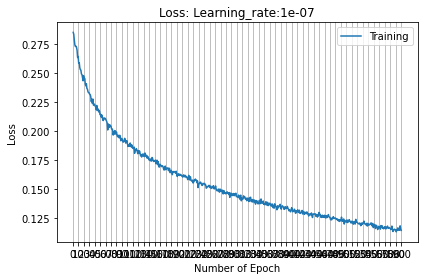

In [80]:
torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

train_epoch_loss = []
test_epoch_loss = []

for e in tqdm(range(1, epoch+1)):
    model.train()
    train_batch_loss = []
    test_batch_loss = []
    # print(f'Epoch {e}')
    for x_train, y_train in train_loader:
        x_batch = torch.squeeze(x_train, 0).to(device)
        y_batch = y_train.to(device)
        x_batch = x_batch.float()
        pred = model(x_batch.float())
        loss_train = criterion(pred,y_batch)
        train_batch_loss.append(loss_train)        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        # scheduler.step()  # Update the learning rate

    train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
    model.eval()
    with torch.no_grad():
        # print('>> test')
        for x_test, y_test in test_loader:
            x_batch = torch.squeeze(x_test, 0).to(device)
            x_batch = x_batch.float()
            y_batch = y_test.to(device)
            # print(x_batch.size())
            # y_batch = torch.Tensor.float(y).to(device)
            # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
            pred = model(x_batch.float())

            # pred = pred.unsqueeze(0)
            # print(pred[:10])
            # print(y_batch[:10])

            loss_test = criterion(pred,y_batch)
            test_batch_loss.append(loss_test)
        test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())

    print(f'Epoch {e}')
    print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
    print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
    # scheduler.step(torch.mean(torch.stack(test_batch_loss)))
    # print(train_batch_loss)
    # print(test_batch_loss)
    # print(f"Training loss: {np.mean(train_batch_loss)}")
    # print(f"Validation loss: {np.mean(test_batch_loss)}")
    # #! implementing early stopping
    # current_val_loss = torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()
    # print(f'Current val loss: {current_val_loss}')
    # print(f'Best val loss: {best_val_loss}')
    # if current_val_loss < best_val_loss:
    #     best_val_loss = current_val_loss
    #     patience_counter = 0  # reset patience counter
    #     # Save the best model
    #     # torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/aa-model_final.pth')

    # else:
    #     patience_counter += 1
    #     if patience_counter >= patience:
    #         print("Early stopping triggered")
    #         torch.save({
    #         'optimizer': optimizer.state_dict(),
    #         'model': model.state_dict(),
    #     }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted_balanced_binned_aa_newdata.pth')
    #         break  # Early stopping
        
print('==='*10)
# torch.save(model.state_dict(), '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/final_seq_model1-44ep.pt')
save_to_file('trials3.txt', 'aa-training_weighted_balanced_mae-binned-rif_newdata-cycliclr' ,epoch, lr=1e-8, fcdr=0.4, l2=1e-8, cnndr=0.05, train_loss = train_epoch_loss, test_loss = test_epoch_loss)

fig, ax = plt.subplots()
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
# ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
fig.savefig(f'./graphs1/aa-loss_lr_{lr}_weighted_balanced.png')
print(f'./graphs1/aa-loss_lr_{lr}_weighted_balanced.png')

# torch.save({
#     'optimizer': optimizer.state_dict(),
#     'model': model.state_dict(),
# }, '/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/seq-{appendix}-{epoch}-{lr}-{cnndr}-{fcdr}-{l2}.pth')

./graphs1/loss_lr_0.0001.png


/tmp/ipykernel_48980/4118118722.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


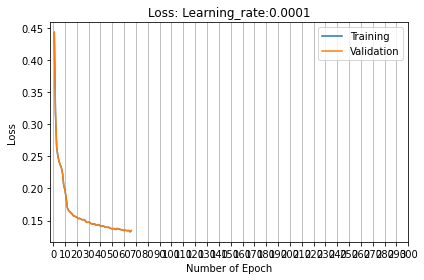

In [ ]:

fig, ax = plt.subplots(facecolor = 'white')
x = np.arange(1, len(np.array(train_epoch_loss).flatten())+1, 1)
ax.plot(x, np.array(train_epoch_loss).flatten(),label='Training')
ax.plot(x, np.array(train_epoch_loss).flatten(),label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
fig.savefig(f'./graphs1/loss_lr_{lr}_long.png')
print(f'./graphs1/loss_lr_{lr}.png')

## AUC

NameError: name 'cnn_dr' is not defined

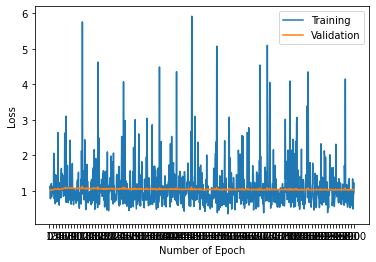

In [ ]:
fig, ax = plt.subplots(facecolor = 'white')
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}, cnn_dr:{cnn_dr}, cnn_dr:{fc_dr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()

In [ ]:
test_dataset = OneHotSeqsDataset(test_data, test_target, one_hot_dtype=torch.float)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, collate_fn=collate_padded_batch ,num_workers=8)

In [ ]:
torch.cuda.empty_cache()
import gc; gc.collect()
# ic.enable()
ic.disable()

model.load_state_dict(torch.load('saved_weights/training_torch_simple_mask_copy_split_model_128f64n-spe30-rand5-100e'))

output = []
model.eval()
with torch.no_grad():

    for x, y in test_loader:
        x_batch = torch.squeeze(x, 0).to(device)
        y_batch = y.to(device)
        x_batch = x_batch.float()
        y_batch = y_batch.float()
        pred = model(x_batch.float())
        output.append(pred)
        
original_value_output = np.exp(output)

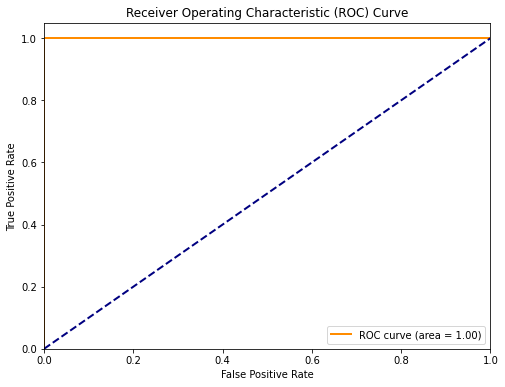

AUC Score: 1.0


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

def calculate_auc(labels, scores):
    """
    Calculate the Area Under the Receiver Operating Characteristic Curve (AUC)
    given true binary labels and prediction scores.
    
    :param labels: List of true binary labels (0 or 1).
    :param scores: List of prediction scores (probabilities or continuous output of the model).
    :return: AUC score.
    """
    auc_score = roc_auc_score(labels, scores)
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(labels, scores)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return auc_score

# Example usage
true_labels = [0, 1, 1, 0, 1]  # True binary labels
prediction_scores = [0.1, 0.4, 0.8, 0.3, 0.7]  # Prediction scores or probabilities

auc_score = calculate_auc(true_labels, prediction_scores)
print(f"AUC Score: {auc_score}")

# testing out hyper-parameters

In [40]:
import subprocess

def run_bash_command(command):
    """
    Runs a bash command and returns its output.
    
    :param command: The command to run as a string.
    :return: A tuple containing the command's stdout and stderr.
    """
    try:
        # Run command
        result = subprocess.run(command, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
        
        # Return stdout and stderr
        return result.stdout, result.stderr
    except subprocess.CalledProcessError as e:
        # Handle errors in the called executable
        return e.stdout, e.stderr
    except Exception as e:
        # Handle other errors related to subprocess.run()
        return None, str(e)

# Example usage
stdout, stderr = run_bash_command('nvidia-smi')
print('STDOUT:', stdout)
print('STDERR:', stderr)

# Example of a command that generates an error
stdout, stderr = run_bash_command('ls non_existent_file')
print('STDOUT:', stdout)
print('STDERR:', stderr)

STDOUT: Wed Mar 27 14:12:50 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:41:00.0 Off |                    0 |
| N/A   37C    P0    36W / 250W |   1221MiB / 32510MiB |     37%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               


In [76]:

def find_range_vectorized(target_values, quest_values):
    # Convert lists to numpy arrays for efficient broadcasting
    target_values =  np.exp(np.array(target_values)) # Reshape for broadcasting
    quest_values =  np.exp(np.array(quest_values))

    # Perform broadcasting to compare each quest value against all target values
    # This creates a boolean matrix where rows correspond to target values and columns to quest values
    in_range_matrix = (target_values / 2 <= quest_values) & (quest_values <= target_values * 2)
    # in_range_matrix = np.abs(np.log2(target_values) - np.log2(quest_values))
    # in_range_matrix  = in_range_matrix  <= 1
    
    # print(mse)
    return in_range_matrix
# Example usage
# target_values = [[10, 20, 30, 40, 50], [10, 20, 30, 40, 50]]
# quest_values = [[25, 5, 60, 1, 1], [10, 20, 30, 40, 50]]

def save_to_file(file_path, appendix, epoch, lr, cnndr, fcdr, l2, train_loss, test_loss):
    train_loss = [float(arr) for arr in train_loss]
    test_loss = [float(arr) for arr in test_loss]
    with open(file_path, "a") as f:
        f.write(f">> {appendix}, Epoch: {epoch}, LR: {lr}, cnnDR: {cnndr},  fnDR: {fcdr}, l2decay: {l2}\n")
        f.write(f"--- Train Loss: {train_loss}\n")
        f.write(f"--- Test Loss: {test_loss}\n")
        
def hyper_params_test(appendix, lr, fc_dr=0,cnn_dr=0, l2=0, epoch=50):
    print('lr:', lr, '| fc_dr:',  fc_dr, '| cnn_dr:', cnn_dr, '| l2:', l2, '==='*10)
    torch.cuda.empty_cache()
    import gc; gc.collect()
    ic.disable()
    
    # stdout, stderr = run_bash_command('nvidia-smi')
    # print('STDOUT:', stdout)
    # print('STDERR:', stderr)
    # model = Model(
    # num_classes=13,
    # num_filters=128,a
    # num_conv_layers=2,
    # num_dense_neurons=64, # batch_size = 64
    # num_dense_layers=2,
    # return_logits=True,
    # dense_dropout_rate=fc_dr,
    # conv_dropout_rate=cnn_dr
    # ).to(device)
    
    model = Model(
    num_classes=3,
    num_filters=64,
    num_conv_layers=2,
    num_dense_neurons=256, # batch_size = 64
    # num_dense_neurons=128, # batch_size = 64
    num_dense_layers=2,
    return_logits=True,
    conv_dropout_rate=cnn_dr,
    dense_dropout_rate=fc_dr
    ).to(device)

    # stdout, stderr = run_bash_command('nvidia-smi')
    # print('STDOUT:', stdout)
    # print('STDERR:', stderr)
    
    epoch = epoch
    batch_size = 128
    lr = lr

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True ,num_workers=8, drop_last=True)
    test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True)
    # criterion = nn.MSELoss()
    criterion = weighted_cross_entropy_loss_fn
    # criterion = F.cross_entropy
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)
    
    ic.disable()
    # ic.enable()
    train_epoch_loss = []
    test_epoch_loss = []

    
    for e in tqdm(range(1, epoch+1)):
        model.train()
        train_batch_loss = []
        test_batch_loss = []
        # print(f'Epoch {e}')
        for x_train, y_train in train_loader:
            x_batch = torch.squeeze(x_train, 0).to(device)
            y_batch = y_train.to(device)
            x_batch = x_batch.float()
            pred = model(x_batch.float())
            # print(pred)
            loss_train = criterion(pred, y_batch)
            # print(y_batch)
            train_batch_loss.append(loss_train)        
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

        train_epoch_loss.append(torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy())
        model.eval()
        with torch.no_grad():
            # print('>> test')
            for x_test, y_test in test_loader:
                x_batch = torch.squeeze(x_test, 0).to(device)
                x_batch = x_batch.float()
                # if np.isnan(y_batch):
                #     continue
                # print(x_batch.size())
                y_batch = y_test.to(device)
                # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
                pred = model(x_batch.float())

                # pred = pred.unsqueeze(0)
                # print(pred[:10])
                # print(y_batch[:10])

                loss_test = criterion(pred, y_batch)
                test_batch_loss.append(loss_test)
            test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())

        print(f'Epoch {e}')
        print(f"Training loss: {torch.mean(torch.stack(train_batch_loss)).detach().cpu().numpy()}")
        print(f"Validation loss: {torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy()}") 
    
     #! testing benchmark
    # testing_dataset = Dataset(test_data, test_target, one_hot_dtype=torch.float, transform=True)
    # testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
    # drugs = ['AMI', 'BDQ', 'CFZ', 'DLM', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'RIF', 'RFB']
    # drugs = ['AMI_MIC','EMB_MIC', 'INH_MIC', 'KAN_MIC', 'RIF_MIC', 'RFB_MIC']

    # model.eval()
    # pred_list = []
    # target_list = []
    # mse_list = []
    # with torch.no_grad():
    #     for x_test, y_test in testing_loader1:
    #         xtest1 = x_test.to(device).float()
    #         ytest1 = y_test.to(device).float()
    #         pred = model(xtest1)
    #         pred_list.append(pred.detach().cpu().numpy()) 
    #         target_list.append(y_test.detach().cpu().numpy())

    # pred_list = np.array(pred_list).squeeze()
    # target_list = np.array(target_list).squeeze()
    # mse_list = (pred_list - target_list)**2
    # mse_out = np.nanmean(mse_list, axis=0)

    # result = find_range_vectorized(target_list, pred_list)

    # # Append output to a file
    # with open('trials3.txt', 'a') as f:
    #     mse_drug_output = f"====MIC-mse: {drugs} {np.mean(mse_out)}\n"
    #     f.write(mse_drug_output)        
    #     ea_accuracy_output = f"====EA-accuracy: {drugs} {np.nanmean(result, axis=0)}\n"
    #     f.write(ea_accuracy_output)
    #     print(mse_drug_output)
    #     print(ea_accuracy_output)
    #     # for x, y in zip(drugs, np.nanmean(result, axis=0).tolist()):
    #     #     print(x, y)                    
            
        # fig, ax = plt.subplots()
        # x = np.arange(1, epoch+1, 1)
        # ax.plot(x, train_epoch_loss,label='Training')
        # # ax.plot(x, test_epoch_loss,label='Validation')
        # ax.legend()
        # ax.set_xlabel("Number of Epoch")
        # ax.set_ylabel("Loss")
        # ax.set_xticks(np.arange(0, epoch+1, 10))
        # ax.set_title(f'Loss: Learning_rate:{lr}')
        # # ax_2 = ax.twinx()
        # # ax_2.plot(history["lr"], "k--", lw=1)
        # # ax_2.set_yscale("log")
        # # ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
        # ax.grid(axis="x")
        # fig.tight_layout()
        # fig.show()
        # fig.savefig(f'./graphs1/aa-loss_lr_{lr}_weighted_balanced.png')
        # print(f'./graphs1/aa-loss_lr_{lr}_weighted_balanced.png')
    save_to_file('trials3.txt', appendix ,epoch, lr, cnn_dr, fc_dr, l2, train_epoch_loss, test_epoch_loss)

    torch.save({
    'optimizer': optimizer.state_dict(),
    'model': model.state_dict(),
}, f'/mnt/storageG1/lwang/Projects/tb_dr_MIC/saved_models/{appendix}-{epoch}-{lr}-{cnn_dr}-{fc_dr}-{l2}_balanced-rif-bi-ag-ce.pth')

In [78]:
torch.cuda.empty_cache()
import gc; gc.collect()

# epoch = 250
# for lr in [1e-4]:
#     for fc_dr in [0.2]:
#         for decay in [1e-9]:
#             for cnn_dr in [0.2, 0.3, 0.4, 0.5]:
#                 hyper_params_test('64-2-256-2-128-log-reg-weighted_balanced', lr, cnn_dr = 0, fc_dr=fc_dr, l2=decay, epoch=epoch)

epoch = 300
for lr in [1e-7]:
    for fc_dr in [0.2, 0.3, 0.4, 0.5]:
        for cnn_dr in [0.05, 0.1, 0.2]:
            for decay in [1e-9]:
                hyper_params_test('aa-64-2-256-2-128-log-reg-weighted_balanced-rif-new-hml3', lr, cnn_dr = cnn_dr, fc_dr=fc_dr, l2=decay, epoch=epoch)
# epoch = 44
# for lr in [1e-4]:
#     for fc_dr in [0.4]:
#         for cnn_dr in [0.4]:
#             for decay in [1e-8]:
#                 hyper_params_test('final_model', lr, fc_dr=fc_dr, cnn_dr=cnn_dr, l2=decay, epoch=epoch)

# epoch = 50
# for lr in [1e-4]:
#     for fc_dr in [0.4]:
#         for cnn_dr in [0, 0.2, 0.3, 0.4, 0.5]:
#             for decay in [1e-8]:
#                 hyper_params_test('64-2-256-2-128-log-reg', lr, fc_dr=fc_dr, cnn_dr=cnn_dr, l2=decay, epoch=epoch)

lr: 1e-07 | fc_dr: 0.2 | cnn_dr: 0.05 | l2: 1e-09 ==============================


  0%|          | 0/300 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 468.00 MiB (GPU 0; 31.75 GiB total capacity; 14.26 GiB already allocated; 239.50 MiB free; 14.71 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

ValueError: x and y must have same first dimension, but have shapes (2,) and (80,)

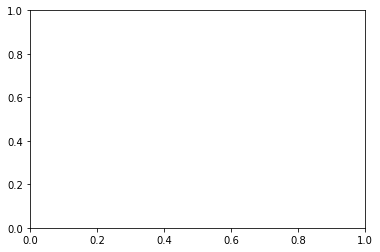

In [20]:
#%%
fig, ax = plt.subplots(facecolor = 'white')
x = np.arange(1, epoch+1, 1)
ax.plot(x, train_epoch_loss,label='Training')
ax.plot(x, test_epoch_loss,label='Validation')
ax.legend()
ax.set_xlabel("Number of Epoch")
ax.set_ylabel("Loss")
ax.set_xticks(np.arange(0, epoch+1, 10))
ax.set_title(f'Loss: Learning_rate:{lr}')
# ax_2 = ax.twinx()
# ax_2.plot(history["lr"], "k--", lw=1)
# ax_2.set_yscale("log")
# ax.set_ylim(ax.get_ylim()[0], history["training_losses"][0])
ax.grid(axis="x")
fig.tight_layout()
fig.show()
#%%
# a = torch.zeros(1, 2, 3, 4, 5, 6)
# b = a.view(a.shape[:2], -1, a.shape[5:])
# %%
# from torchviz import make_dot
# x = torch.randn(2, 4, 56).to(device)
# m = model_torch_simple.raw_seq_model().to(device)
# y = m(x)
# make_dot(y, params=dict(list(m.named_parameters()))).render("cnn_torchviz", format="png")

# Testing

In [24]:
testing_dataset = OneHotSeqsDataset(test_data, test_target, one_hot_dtype=torch.float, transform=True)
testing_loader = DataLoader(dataset=testing_dataset, batch_size=128, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)

## batch running

In [18]:

save_path = '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted.pth'

# Load the saved file
checkpoint = torch.load(save_path)
ic.disable()

# Initialize the model and optimizer
model = Model(
num_classes=13,
num_filters=64,
num_conv_layers=2,
num_dense_neurons=256, # batch_size = 64
# num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=True,
conv_dropout_rate=0,
dense_dropout_rate=0.2
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=1e-9)

# optimizer = optimizer_class(model.parameters(), ...)  # Add the necessary arguments as per your optimizer's initialization method

# Load the model and optimizer states
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

# Make sure to call .eval() or .train() on your model depending on what you're planning to do next
model.eval()  # For inference
# or
# model.train()  # For further training


pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader:
        x_batch = torch.squeeze(x_test, 0).to(device)
        x_batch = x_batch.float()
        y_batch = y_test.float().to(device)
        # print(x_batch.size())
        # y_batch = torch.Tensor.float(y).to(device)
        # x_batch = x_batch.permute(0, 3, 1, 2).to(device)
        pred = model(x_batch.float())
        pred_list.append(pred)
        target_list.append(y_batch)
        # pred = pred.unsqueeze(0)
        loss_test = criterion(y_batch, pred)
        mse_list.append(loss_test)
        # test_batch_loss.append(loss_test)
        # test_epoch_loss.append(torch.mean(torch.stack(test_batch_loss)).detach().cpu().numpy())


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted.pth'

## Overall test

In [134]:
testing_dataset = Dataset(test_data, test_target, one_hot_dtype=torch.float, transform=False)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)

#### for in memory model

In [81]:
testing_dataset = Dataset(test_data, test_target, one_hot_dtype=torch.float, transform=False)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=1, shuffle=True, drop_last=True)

model.eval()  # For inference

ic.disable()
model.eval()
pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader1:
        xtest1 = x_test.to(device).float()
        ytest1 = y_test.to(device).float()
        pred = model(xtest1)
        pred_list.append(np.argmax(pred.detach().cpu().numpy())) 
        target_list.append(y_test.detach().cpu().numpy())
target_list = np.array(target_list).flatten()

In [83]:
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix

def calculate_metrics(true_labels, predictions):
    """
    Calculates accuracy, F1 score, and confusion matrix for the given true and predicted labels.

    Parameters:
    - true_labels: List or array of true labels
    - predictions: List or array of predicted labels

    Returns:
    - accuracy: Overall accuracy of predictions
    - f1: Weighted average F1 score
    - conf_matrix: Multiclass confusion matrix
    """
    # Ensure inputs are numpy arrays for consistency
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Calculate accuracy
    accuracy = np.sum(true_labels == predictions) / len(true_labels)

    # Calculate F1 score
    f1 = f1_score(true_labels, predictions, average='weighted')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    return accuracy, f1, conf_matrix

# Example usage
# true_labels = [0, 1, 2, 1, 0, 2, 1, 0]
# predictions = [0, 2, 2, 1, 0, 0, 1, 0]

accuracy, f1, conf_matrix = calculate_metrics(target_list, pred_list)
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

Accuracy: 0.7516425755584757
F1 Score: 0.7782551120534332


In [95]:
accuracy

0.7516425755584757

In [93]:
_0 = 0
_1 = 0
_2 = 0
for x,y in zip(pred_list, target_list):
    if x==y:
        if x == 0:
            _0+=1
        elif x == 1:
            _1+=1
        else:
            _2+=1
print(_0, _2, _1)
print(test_target.value_counts())
print(_0 / test_target.value_counts()[0],
      _2 / test_target.value_counts()[2],
      _1 / test_target.value_counts()[1])

316 212 44
RIF_MIC
0          440
2          237
1           84
Name: count, dtype: int64
0.7181818181818181 0.8945147679324894 0.5238095238095238


In [94]:
_0 = 0
_1 = 0
_2 = 0
for x,y in zip(pred_list, target_list):
    if x!=y:
        if x == 0:
            _0+=1
        elif x == 1:
            _1+=1
        else:
            _2+=1
print(_0, _2, _1)


48 13 128


In [86]:
np.array(pred_list)

array([0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 1, 1, 1, 1, 2, 1, 1, 0, 1, 0, 0, 2,
       2, 2, 2, 2, 1, 2, 1, 0, 0, 0, 0, 2, 2, 0, 1, 2, 0, 2, 2, 0, 1, 2,
       0, 2, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 1, 0, 1, 2, 0, 2, 2, 0, 0,
       2, 0, 0, 2, 1, 0, 2, 0, 0, 0, 0, 2, 0, 1, 0, 2, 1, 1, 2, 1, 0, 2,
       0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 1, 2, 0, 0, 1, 2, 2, 2, 2, 0, 2,
       0, 2, 0, 0, 2, 1, 2, 1, 0, 2, 1, 0, 0, 0, 1, 0, 2, 0, 2, 2, 1, 0,
       0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 0, 0, 2, 1, 0,
       0, 0, 2, 0, 0, 0, 1, 2, 0, 0, 2, 1, 2, 0, 0, 1, 1, 1, 1, 0, 0, 2,
       2, 1, 0, 2, 0, 0, 1, 0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 2, 1, 2, 0, 2, 1, 2, 2, 0, 0, 0, 2, 1, 1, 0,
       2, 2, 2, 0, 2, 2, 0, 2, 1, 2, 0, 1, 2, 2, 1, 0, 2, 0, 0, 0, 2, 1,
       0, 0, 2, 0, 2, 1, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 2, 2, 0, 1, 1, 1,
       0, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       2, 0, 2, 1, 1, 1, 2, 1, 0, 0, 0, 2, 0, 1, 0,

ordinal data

In [28]:
train_target.value_counts()

RIF_MIC
0          4323
2          1562
1           898
Name: count, dtype: int64

In [ ]:
for x in train_target.values:
    print(x)

In [20]:
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix

def calculate_metrics(true_labels, predictions):
    """
    Calculates accuracy, F1 score, and confusion matrix for the given true and predicted labels.

    Parameters:
    - true_labels: List or array of true labels
    - predictions: List or array of predicted labels

    Returns:
    - accuracy: Overall accuracy of predictions
    - f1: Weighted average F1 score
    - conf_matrix: Multiclass confusion matrix
    """
    # Ensure inputs are numpy arrays for consistency
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # Calculate accuracy
    accuracy = np.sum(true_labels == predictions) / len(true_labels)

    # Calculate F1 score
    f1 = f1_score(true_labels, predictions, average='weighted')

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)

    return accuracy, f1, conf_matrix

# Example usage
true_labels = [0, 1, 2, 1, 0, 2, 1, 0]
predictions = [0, 2, 2, 1, 0, 0, 1, 0]

accuracy, f1, conf_matrix = calculate_metrics(target_list, pred_list)
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")


Accuracy: 0.24005305039787797
F1 Score: 0.38716577540106956


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


# First, let's write a function that accepts a list of values and a list of thresholds.
# The function will compare each value with its corresponding threshold and return a list of binary values.
thresholds = [2, 0.5, 0.5, 0.25, 8, 8, 0.8, 8, 8, 2, 2, 1, 0.25]

def threshold_binary_list(values, thresholds):
    # This function will compare values with thresholds and return a binary list
    values = np.exp(values)
    binary_list = [1 if value >= threshold else 0 for value, threshold in zip(values, thresholds)]
    return binary_list

pred_list_rs = []
target_list_rs = []

for x in tqdm(pred_list):
    pred_list_rs.append(threshold_binary_list(x[0], thresholds))
for x in tqdm(target_list):
    target_list_rs.append(threshold_binary_list(x[0], thresholds))




np.random.seed(0)  # Seed for reproducibility
y_true = np.array(target_list_rs)
y_pred = np.array(pred_list_rs)

# Initialize lists to store metrics for each column
column_accuracies = []
column_f1_scores = []
column_conf_matrices = []

# Calculate accuracy, F1 score, and confusion matrix for each column
for i in range(y_true.shape[1]):
    column_accuracies.append(accuracy_score(y_true[:, i], y_pred[:, i]))
    column_f1_scores.append(f1_score(y_true[:, i], y_pred[:, i], zero_division=0))
    column_conf_matrices.append(confusion_matrix(y_true[:, i], y_pred[:, i]))

# Calculate overall metrics for the entire matrix
overall_accuracy = accuracy_score(y_true.ravel(), y_pred.ravel())
overall_f1_score = f1_score(y_true.ravel(), y_pred.ravel(), zero_division=0)
overall_conf_matrix = confusion_matrix(y_true.ravel(), y_pred.ravel())

# Output the results
column_metrics = list(zip(column_accuracies, column_f1_scores, column_conf_matrices))
overall_metrics = (overall_accuracy, overall_f1_score, overall_conf_matrix)

column_metrics, overall_metrics

result_df = pd.DataFrame(columns=['Drugs','accuracy', 'f1_score', 'True Negative (TN)', 'False Positive (FP)','False Negative (FN)', 'True Positive (TP)'])
result_df['Drugs'] = ['AMI', 'BDQ', 'CFZ', 'DLM', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'RIF', 'RFB']
result_df['accuracy'] = column_accuracies
result_df['f1_score'] = column_f1_scores
result_df['True Negative (TN)'] = np.array(column_conf_matrices)[:,0,0]
result_df['False Positive (FP)'] = np.array(column_conf_matrices)[:,0,1]
result_df['False Negative (FN)'] = np.array(column_conf_matrices)[:,1,0]
result_df['True Positive (TP)'] = np.array(column_conf_matrices)[:,1,1]
# print(np.array(column_conf_matrices)[:,0,0])
# print(np.array(column_conf_matrices)[:,0,1])
# print(np.array(column_conf_matrices)[:,1,0])
# print(np.array(column_conf_matrices)[:,1,1])
result_df['Sensitivity'] = result_df['True Positive (TP)'] / (result_df['True Positive (TP)'] + result_df['False Negative (FN)'])
result_df['Specificity'] = result_df['True Negative (TN)'] / (result_df['True Negative (TN)'] + result_df['False Positive (FP)'])

pred_list = np.array(pred_list).squeeze()
target_list = np.array(target_list).squeeze()
mse_list = (pred_list - target_list)**2
mse_out = np.nanmean(mse_list, axis=0)
result_df['MSE'] = mse_out

print(result_df)

#### for saved model

In [51]:
testing_dataset = OneHotSeqsDataset(test_data, test_target, one_hot_dtype=torch.float, transform=True)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)


save_path = '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/saved_models/aa-model_weighted.pth'

# Load the saved file
checkpoint = torch.load(save_path)
ic.disable()

# Initialize the model and optimizer
model = Model(
num_classes=13,
num_filters=64,
num_conv_layers=2,
num_dense_neurons=256, # batch_size = 64
# num_dense_neurons=128, # batch_size = 64
num_dense_layers=2,
return_logits=True,
conv_dropout_rate=0,
dense_dropout_rate=0.2
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr,  weight_decay=1e-9)

# optimizer = optimizer_class(model.parameters(), ...)  # Add the necessary arguments as per your optimizer's initialization method

# Load the model and optimizer states
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

# Make sure to call .eval() or .train() on your model depending on what you're planning to do next
model.eval()  # For inference

ic.disable()
model.eval()
pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader1:
        xtest1 = x_test.to(device).float()
        ytest1 = y_test.to(device).float()
        pred = model(xtest1)
        pred_list.append(pred.detach().cpu().numpy()) 
        target_list.append(y_test.detach().cpu().numpy())

In [25]:
# First, let's write a function that accepts a list of values and a list of thresholds.
# The function will compare each value with its corresponding threshold and return a list of binary values.

def threshold_binary_list(values, thresholds):
    # This function will compare values with thresholds and return a binary list
    values = np.exp(values)
    binary_list = [1 if value >= threshold else 0 for value, threshold in zip(values, thresholds)]
    return binary_list

# List of thresholds as per the image provided by the user
thresholds = [2, 0.5, 0.5, 0.25, 8, 8, 0.8, 8, 8, 2, 2, 1, 0.25]

# Example list of values to be checked against the thresholds
values = [3, 0.7, 0.4, 0.3, 10, 5, 1, 9, 7, 2, 3, 0.5, 0.3]  # This is a placeholder

# Get the binary list using the function defined above
binary_list = threshold_binary_list(pred_list[0][0], thresholds)
binary_list


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

### Getting accuracy and stuff

In [52]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


# First, let's write a function that accepts a list of values and a list of thresholds.
# The function will compare each value with its corresponding threshold and return a list of binary values.
thresholds = [2, 0.5, 0.5, 0.25, 8, 8, 0.8, 8, 8, 2, 2, 1, 0.25]

def threshold_binary_list(values, thresholds):
    # This function will compare values with thresholds and return a binary list
    values = np.exp(values)
    binary_list = [1 if value >= threshold else 0 for value, threshold in zip(values, thresholds)]
    return binary_list

pred_list_rs = []
target_list_rs = []

for x in tqdm(pred_list):
    pred_list_rs.append(threshold_binary_list(x[0], thresholds))
for x in tqdm(target_list):
    target_list_rs.append(threshold_binary_list(x[0], thresholds))




np.random.seed(0)  # Seed for reproducibility
y_true = np.array(target_list_rs)
y_pred = np.array(pred_list_rs)

# Initialize lists to store metrics for each column
column_accuracies = []
column_f1_scores = []
column_conf_matrices = []

# Calculate accuracy, F1 score, and confusion matrix for each column
for i in range(y_true.shape[1]):
    column_accuracies.append(accuracy_score(y_true[:, i], y_pred[:, i]))
    column_f1_scores.append(f1_score(y_true[:, i], y_pred[:, i], zero_division=0))
    column_conf_matrices.append(confusion_matrix(y_true[:, i], y_pred[:, i]))

# Calculate overall metrics for the entire matrix
overall_accuracy = accuracy_score(y_true.ravel(), y_pred.ravel())
overall_f1_score = f1_score(y_true.ravel(), y_pred.ravel(), zero_division=0)
overall_conf_matrix = confusion_matrix(y_true.ravel(), y_pred.ravel())

# Output the results
column_metrics = list(zip(column_accuracies, column_f1_scores, column_conf_matrices))
overall_metrics = (overall_accuracy, overall_f1_score, overall_conf_matrix)

column_metrics, overall_metrics

result_df = pd.DataFrame(columns=['Drugs','accuracy', 'f1_score', 'True Negative (TN)', 'False Positive (FP)','False Negative (FN)', 'True Positive (TP)'])
result_df['Drugs'] = ['AMI', 'BDQ', 'CFZ', 'DLM', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'RIF', 'RFB']
result_df['accuracy'] = column_accuracies
result_df['f1_score'] = column_f1_scores
result_df['True Negative (TN)'] = np.array(column_conf_matrices)[:,0,0]
result_df['False Positive (FP)'] = np.array(column_conf_matrices)[:,0,1]
result_df['False Negative (FN)'] = np.array(column_conf_matrices)[:,1,0]
result_df['True Positive (TP)'] = np.array(column_conf_matrices)[:,1,1]
# print(np.array(column_conf_matrices)[:,0,0])
# print(np.array(column_conf_matrices)[:,0,1])
# print(np.array(column_conf_matrices)[:,1,0])
# print(np.array(column_conf_matrices)[:,1,1])
result_df['Sensitivity'] = result_df['True Positive (TP)'] / (result_df['True Positive (TP)'] + result_df['False Negative (FN)'])
result_df['Specificity'] = result_df['True Negative (TN)'] / (result_df['True Negative (TN)'] + result_df['False Positive (FP)'])

pred_list = np.array(pred_list).squeeze()
target_list = np.array(target_list).squeeze()
mse_list = (pred_list - target_list)**2
mse_out = np.nanmean(mse_list, axis=0)
result_df['MSE'] = mse_out

print(result_df)

100%|██████████| 1206/1206 [00:00<00:00, 120868.12it/s]


In [142]:
# testing_dataset = OneHotSeqsDataset(test_data, test_target, one_hot_dtype=torch.float, transform=True)
testing_loader1 = DataLoader(dataset=testing_dataset, batch_size=1, collate_fn=collate_padded_batch, num_workers=8, shuffle=True, drop_last=True)
ic.disable()
model.eval()
pred_list = []
target_list  = []
mse_list = []
with torch.no_grad():
    for x_test, y_test in testing_loader1:
        xtest1 = x_test.to(device).float()
        ytest1 = y_test.to(device).float()
        pred = model(xtest1)
        pred_list.append(pred.detach().cpu().numpy()) 
        target_list.append(y_test.detach().cpu().numpy())

## Mic calc

In [54]:
pred_list = np.array(pred_list).squeeze()
target_list = np.array(target_list).squeeze()
mse_list = (pred_list - target_list)**2
mse_out = np.nanmean(mse_list, axis=0)
print(mse_out)
print(np.mean(mse_out))

[0.72782607 0.77394133 0.96627392 0.99732814 0.57384106 0.71862384
 1.40909006 0.62500867 0.68552988 0.42204546 0.90296875 1.86967643
 1.116575  ]
0.9068252765540421


In [147]:
pred_list = np.array(pred_list).squeeze()
target_list = np.array(target_list).squeeze()
mse_list = (np.exp(pred_list) - np.exp(target_list))**2
mse_out = np.nanmean(mse_list, axis=0)
print(mse_out)
print(np.mean(mse_out))

[1.99657691e+01 2.19492095e-02 1.20861531e-01 1.84303685e-02
 2.18870026e+01 1.48684251e+01 1.62012543e+01 2.61311525e+01
 6.15298126e+00 2.21063227e-01 1.96245250e+00 1.24928044e+01
 9.46748127e-01]
9.30699186242598


## Ea calc

In [129]:
def find_range_vectorized(target_values, quest_values):
    # Convert lists to numpy arrays for efficient broadcasting
    target_values =  np.exp(np.array(target_values)) # Reshape for broadcasting
    quest_values =  np.exp(np.array(quest_values))

    # Perform broadcasting to compare each quest value against all target values
    # This creates a boolean matrix where rows correspond to target values and columns to quest values
    in_range_matrix = (target_values / 2 <= quest_values) & (quest_values <= target_values * 2)
    # in_range_matrix = np.abs(np.log2(target_values) - np.log2(quest_values))
    # in_range_matrix  = in_range_matrix  <= 1
    
    # print(mse)
    return in_range_matrix
# Example usage
# target_values = [[10, 20, 30, 40, 50], [10, 20, 30, 40, 50]]
# quest_values = [[25, 5, 60, 1, 1], [10, 20, 30, 40, 50]]
result = find_range_vectorized(target_list, pred_list)

In [148]:
np.exp(pred_list[0])

array([0.21734211, 0.04858502, 0.07807854, 0.01177044, 1.1826788 ,
       1.069281  , 0.02535057, 1.8139412 , 0.41462198, 0.45923612,
       0.28088352, 0.1602019 , 0.06000657], dtype=float32)

In [135]:
target_values_ =  np.exp(np.array(target_list)) # Reshape for broadcasting
quest_values_ =  np.exp(np.array(pred_list))


In [111]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score


for i in range(result.shape[0]):
    f1 = f1_score(y_true, result[i, :])
    accuracy = accuracy_score(y_true, result[i, :])
    print(f"Model {i+1} - F1 Score: {f1}, Accuracy: {accuracy}")


NameError: name 'y_true' is not defined

In [ ]:
def EA_calc(target_matrix: np.array):
    drugs = ['AMI', 'BDQ', 'CFZ', 'DLM', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'RIF', 'RFB']
    for x, drug in zip(range(target_matrix.shape[1]), drugs):
        ea_count = len([item for item in target_matrix[:,x] if item == True])
        ea_rate = (ea_count / len(target_matrix[:,x])) * 100
        print(drug, ea_rate)
        
def MSE_calc(target_matrix: np.array):
    drugs = ['AMI', 'BDQ', 'CFZ', 'DLM', 'EMB', 'ETH', 'INH', 'KAN', 'LEV', 'LZD', 'MXF', 'RIF', 'RFB']
    for x, drug in zip(range(target_matrix.shape[1]), drugs):
        mse = np.mean(target_matrix[:,x])
        print(drug, mse)
        

# Explanable AI

### Sensitivity analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Assume `input_data` is your input tensor, and `feature_index` is the index of the feature to perturb
perturbation_range = np.linspace(0, 1, num=20)  # Example range of perturbation
original_value = input_data[0, feature_index].item()  # Store original value

output_changes = np.zeros((len(perturbation_range), 13))  # Store changes in outputs

for i, perturb in enumerate(perturbation_range):
    input_data[0, feature_index] = original_value + perturb  # Perturb feature value
    with torch.no_grad():
        outputs = model(input_data).numpy()  # Get model output
    output_changes[i] = outputs  # Record the change

# Reset the perturbed feature to its original value
input_data[0, feature_index] = original_value

# Example analysis for one output
plt.figure(figsize=(10, 6))
for output_index in range(13):
    plt.plot(perturbation_range, output_changes[:, output_index], label=f'Output {output_index+1}')

plt.xlabel('Perturbation')
plt.ylabel('Output Change')
plt.title('Sensitivity Analysis of Feature X on All Outputs')
plt.legend()
plt.show()


### SHAP

In [ ]:
import torch
import numpy as np

def model_wrapper(x):
    with torch.no_grad():
        # Convert the input numpy array to a PyTorch tensor
        tensor_x = torch.tensor(x, dtype=torch.float32)
        # Make a prediction with your model
        model_output = model(tensor_x)
        # Convert the prediction back to a numpy array
        return model_output.numpy()


In [ ]:
import shap

# Sample data for initialization (e.g., a batch from your training data)
X_sample = np.array([...])  # Replace with your actual numpy array

# Initialize the explainer
explainer = shap.KernelExplainer(model_wrapper, X_sample)

# Choose the instance you want to explain
X_instance = np.array([...])  # Replace with the instance in numpy array format

# Calculate SHAP values
shap_values = explainer.shap_values(X_instance)

# Plotting the SHAP values
shap.initjs()  # Initializes JavaScript visualization in Jupyter Notebooks
shap.force_plot(explainer.expected_value, shap_values, X_instance)


### Counterfactual

In [ ]:
### SHAP